In [1]:
#Imports
import json
import numpy as np
import pandas as pd
import csv
import scipy.stats
import matplotlib.pyplot as plt
import seaborn as sns
import os
from django.contrib.admin.utils import flatten
import pyhrv
import pyhrv.nonlinear as nl
import statistics
from scipy.stats.stats import pearsonr 

In [3]:
# Calcula el std de los mínimos porcentuales

path = '/media/leandro/Volumen1TB/Lean/Analizador_imagenes_calcio/Luis/analisis/'
experiments = os.listdir(path + 'jsons/')
min_exp = pd.DataFrame()
for i in range(0,len (experiments)):
    experiment = experiments[i]
    with open(path + 'jsons/' + experiment) as f:
        min_file = json.load(f)['image']['min_peaks_intensities']
        min_exp[i] = experiment,(np.array(min_file)*100/min_file[0]).std()
min_exp = pd.DataFrame (min_exp.T)
min_exp.columns = ['file','std_min']

UnicodeDecodeError: 'utf-8' codec can't decode byte 0x8f in position 22: invalid start byte

In [44]:
# Extrae los mínimos por slice

path = '/media/leandro/Volumen1TB/Lean/Analizador_imagenes_calcio/Luis/analisis/'
experiments = os.listdir(path + 'jsons/')
min_exp = pd.DataFrame()
for i in range(0,len (experiments)):
    experiment = experiments[i]
    if 'json' in experiment:
        with open(path + 'jsons/' + experiment) as f:
            min_file = json.load(f)['image']['min_peaks_intensities']
            min_exp[i] = experiment,(np.array(min_file)*100/min_file[0])
min_exp = pd.DataFrame (min_exp.T)
min_exp.columns = ['file','mins']

/home/leandro/.local/lib/python3.8/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


In [3]:
# Filtrado por tratamiento y frecuencia

def tau_filter(tratamiento,frecuencia,dosis,df):
    tabulado_filter = tabulado[(tabulado['tratamiento']==tratamiento) & (tabulado['frecuencia']== frecuencia) & (tabulado['dosis']== dosis)].reset_index(drop=True)
    tau = pd.DataFrame(columns = ['file','mins'])
    for j in range(0,len (tabulado_filter)):
        carpeta = tabulado_filter['carpeta'][j]
        foto = tabulado_filter['foto'][j]
        for i in range(0,len (df)):
            try:
                df_carpeta = df[df['file'].str.contains(carpeta)]
                if foto in df_carpeta['file'][i]:
                    tau.loc[j] = df_carpeta.loc[i]
            except KeyError:
                pass
    return tau

In [4]:
path = '/media/leandro/Volumen1TB/Lean/Analizador_imagenes_calcio/Luis/seleccion/'
tabulado = pd.read_csv(path + 'tabulado_imagenes.csv')
del tabulado['Unnamed: 0']

In [45]:
tabulado_control5 = tau_filter('c', 5,0, min_exp)
tabulado_vk5 = tau_filter('vk', 5, 5,min_exp)
tabulado_dan5 = tau_filter('d', 5, 5,min_exp)

In [46]:
tabulado_control5 = tabulado_control5.reset_index(drop=True)
tabulado_vk5 = tabulado_vk5.reset_index(drop=True)
tabulado_dan5 = tabulado_dan5.reset_index(drop=True)

In [7]:
def outliers(column):
    Q1 = column.quantile(0.25)
    Q3 = column.quantile(0.75)
    IQR = Q3 - Q1
    idx = ~((column < (Q1 - 1.5 * IQR)) | (column > (Q3 + 1.5 * IQR)))
    return idx

In [57]:
tabulado_control5 = tabulado_control5[outliers(tabulado_control5['std_min'])]
tabulado_vk5 = tabulado_vk5[outliers(tabulado_vk5['std_min'])]
tabulado_dan5 = tabulado_dan5[outliers(tabulado_dan5['std_min'])]

KeyError: 'std_min'

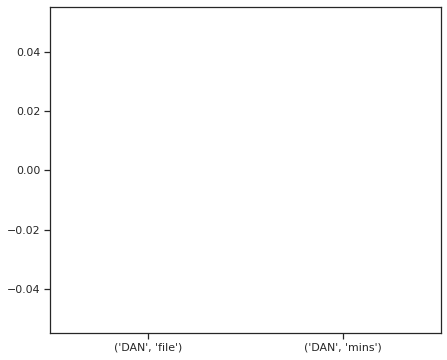

In [11]:
df = pd.concat ([tabulado_control5,tabulado_vk5,tabulado_dan5], axis=1, sort=False, keys=['C', 'VK','DAN'])
df
sns.set(style="ticks")

# Initialize the figure with a logarithmic x axis
f, ax = plt.subplots(figsize=(7, 6))


sns.boxplot(data=df)

sns.swarmplot(data=df, linewidth=2)
f.savefig("std_min%.png")

In [ ]:
df.to_excel('std_min%.xlsx', engine = 'xlsxwriter')

In [ ]:
print(scipy.stats.kstest(tabulado_control5['std_min'],tabulado_dan5['std_min']))
print(scipy.stats.kstest(tabulado_control5['std_min'],tabulado_vk5['std_min']))
print(scipy.stats.kstest(tabulado_vk5['std_min'],tabulado_dan5['std_min']))
print(scipy.stats.shapiro(tabulado_control5['std_min']))

In [7]:
DI_control = pd.read_csv(path + 'DI_control.csv')

In [8]:
min5 = []
for i in range(0,len(DI_control['file'])):
    cel = DI_control['file'][i]
    filtro_wc5 = tabulado_control5[(tabulado_control5['file'].str.contains(cel) == True)]
    min5.append (filtro_wc5['std_min'].values)
DI_control['min5'] = min5

KeyError: 'std_min'

In [ ]:
DI_control.drop(4, inplace=True)
DI_control.drop(5, inplace=True)
DI_control.drop(6, inplace=True)
DI_control.drop(9, inplace=True)
DI_control.drop(21, inplace=True)
b = [j for i in DI_control['min5'].tolist() for j in i]
a = DI_control['DISCORDANCE 5 Hz']

In [ ]:
from scipy.stats.stats import pearsonr 
print (pearsonr(DI_control['DISCORDANCE 5 Hz'],b))

In [ ]:
plt.scatter(a,b)

## POINCARÉ - SD

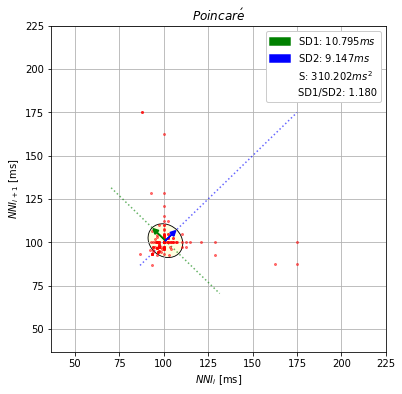

ReturnTuple(poincare_plot=<Figure size 432x432 with 1 Axes>, sd1=10.795045225157256, sd2=9.146816873219702, sd_ratio=0.8473162161380807, ellipse_area=310.201806787823)


In [8]:
# Estructuración de datos para Poincaré

min_c5 = [l.tolist() for l in tabulado_control5['mins']]
min_c5 = flatten(min_c5)

min_vk5 = [l.tolist() for l in tabulado_vk5['mins']]
min_vk5 = flatten(min_vk5)

min_dan5 = [l.tolist() for l in tabulado_dan5['mins']]
min_dan5 = flatten(min_dan5)

# Load sample data
nni = min_dan5

# Compute Poincaré using NNI series
results = nl.poincare(nni)

# Print SD1
print(results)

# results[0].savefig("c5.png")

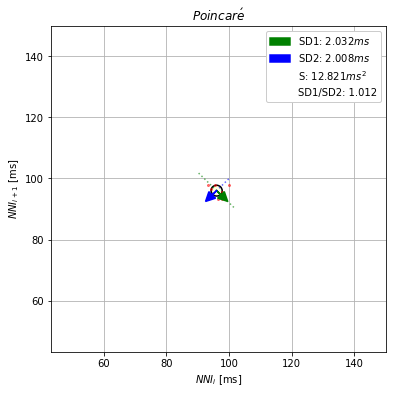

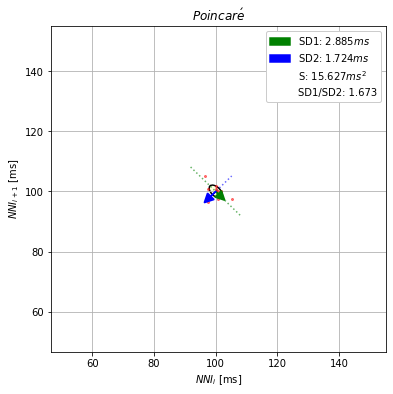

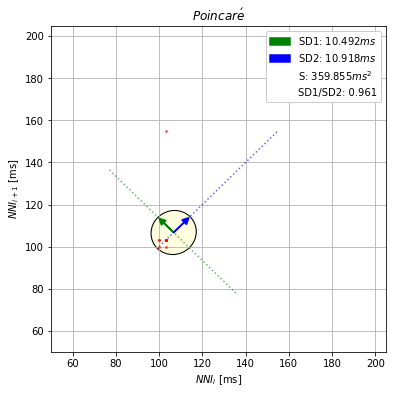

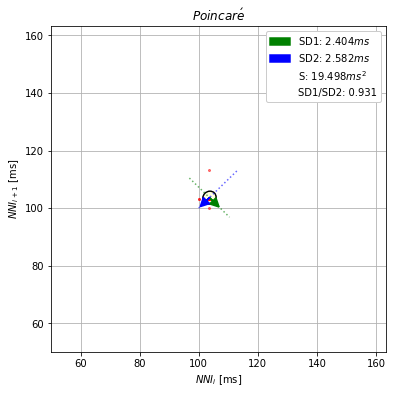

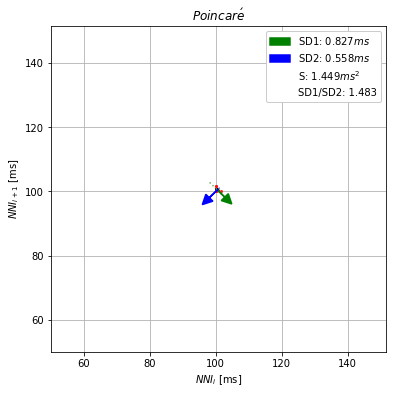

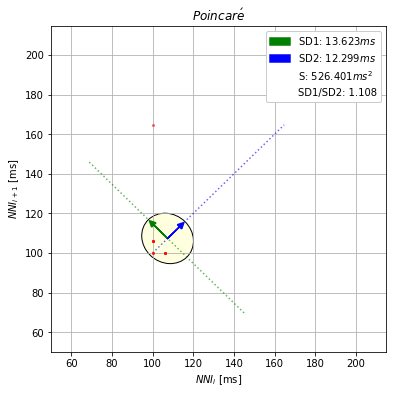

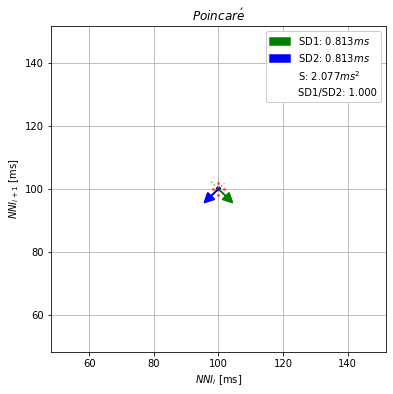

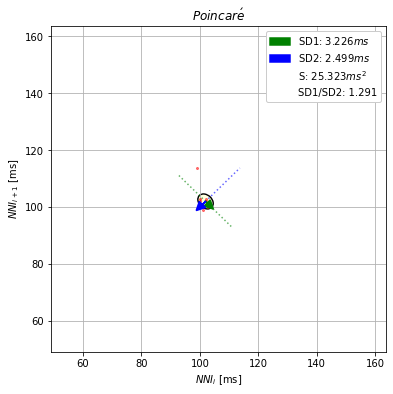

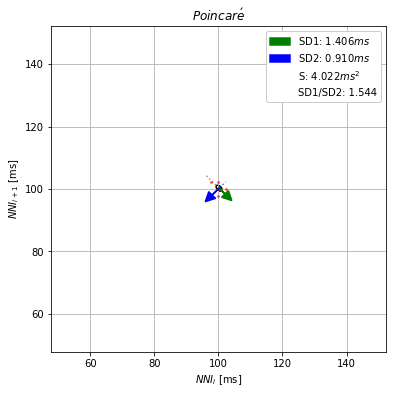

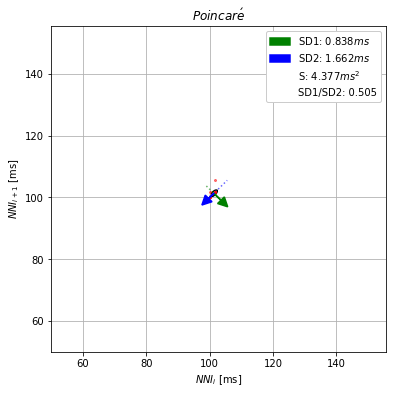

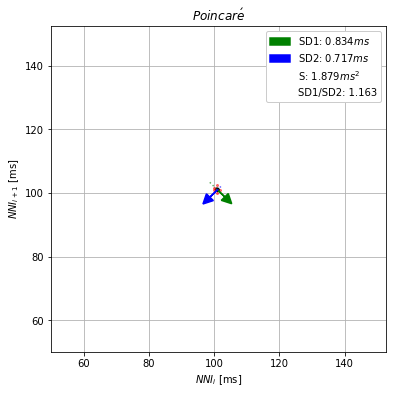

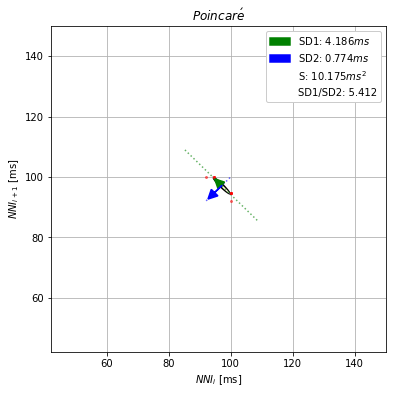

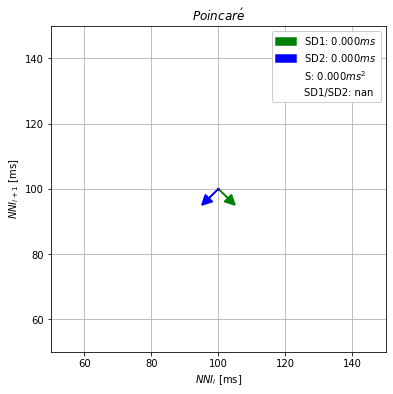

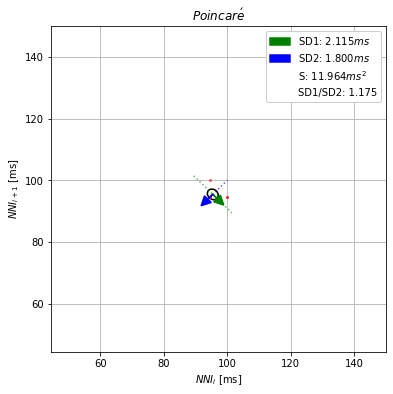

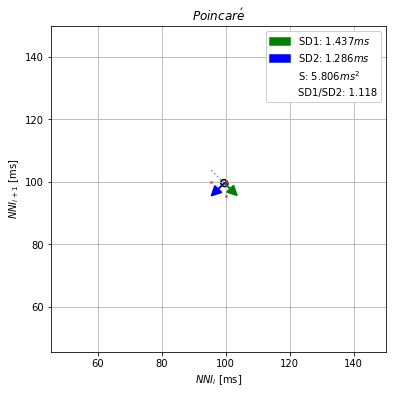

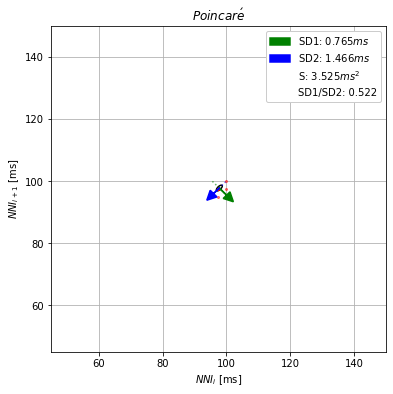

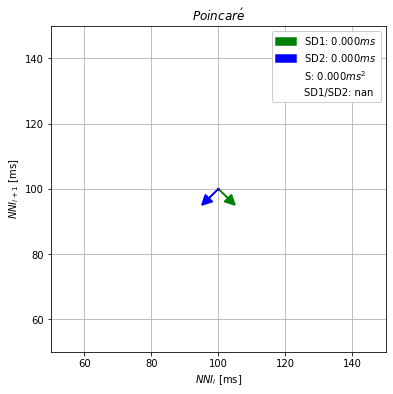

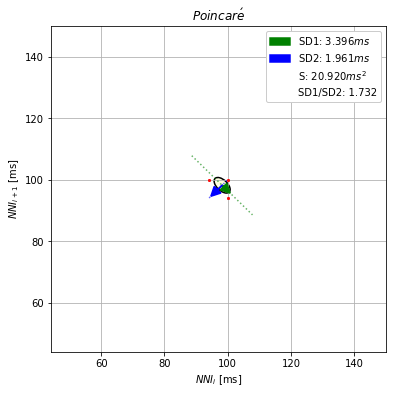

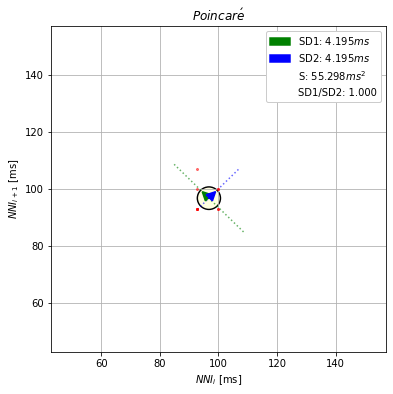

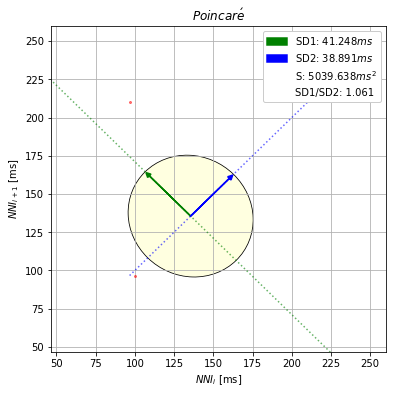

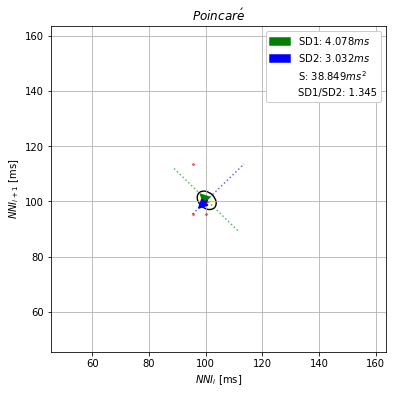

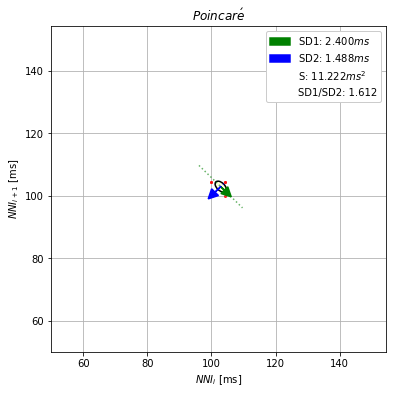

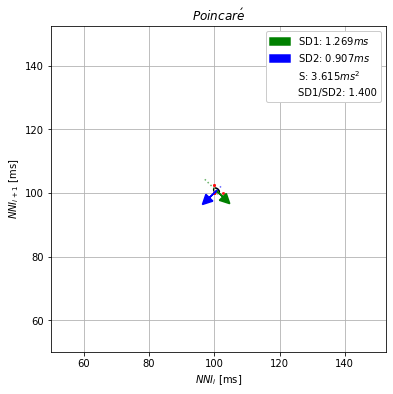

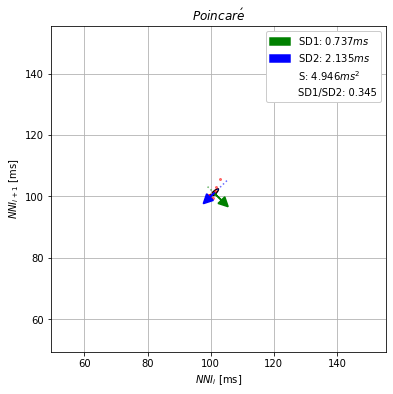

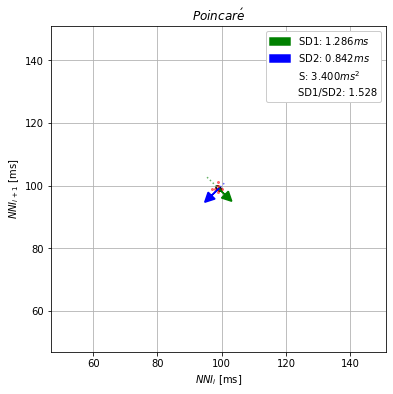

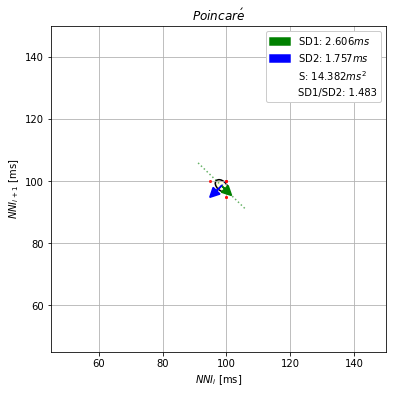

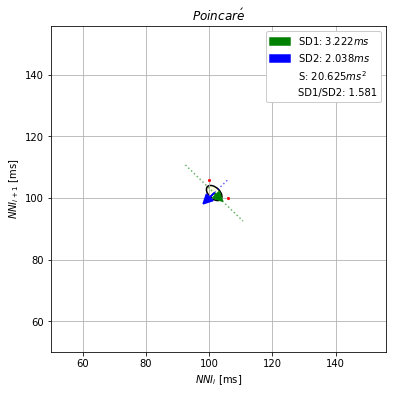

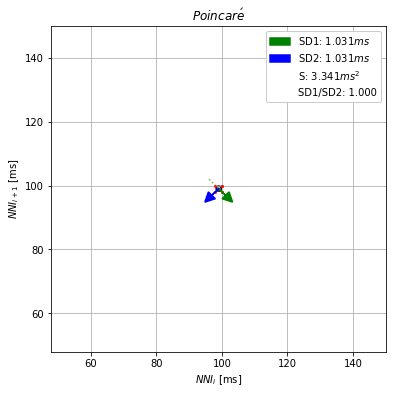

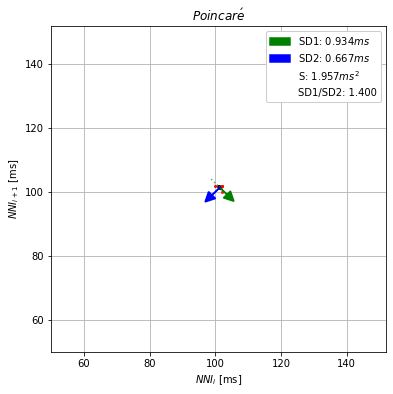

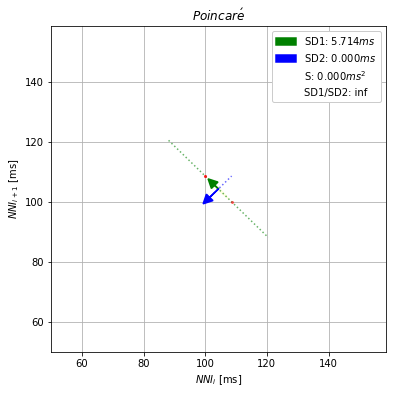

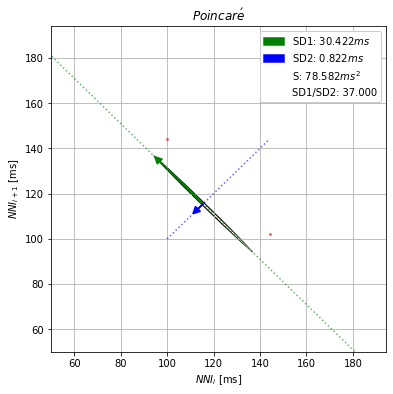

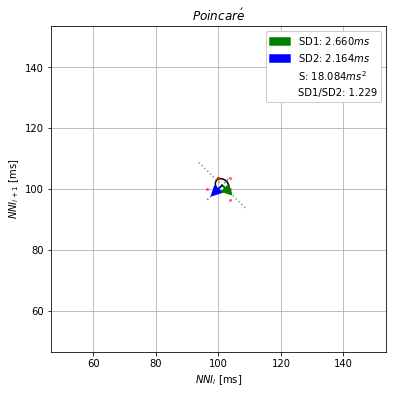

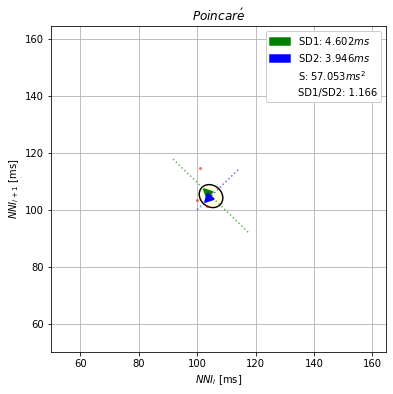

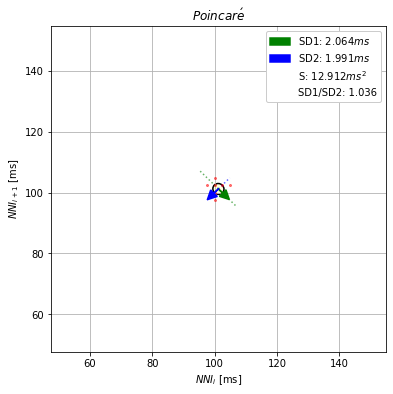

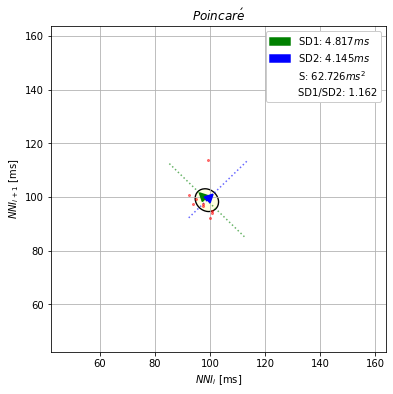

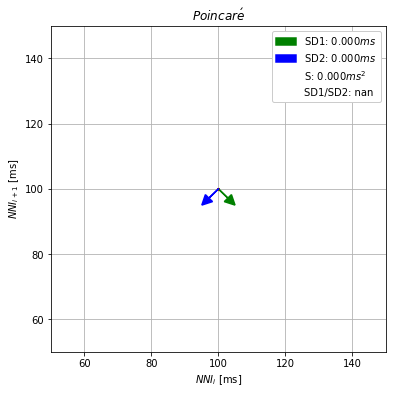

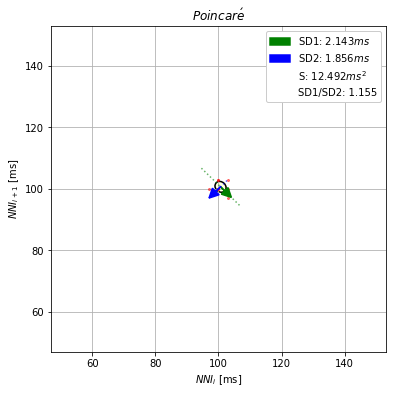

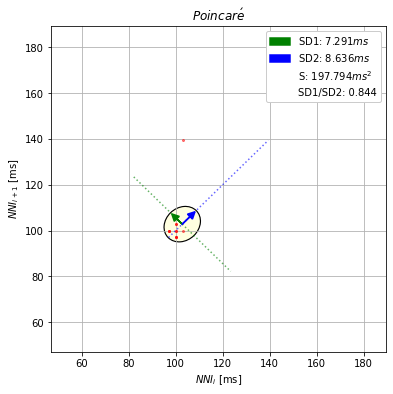

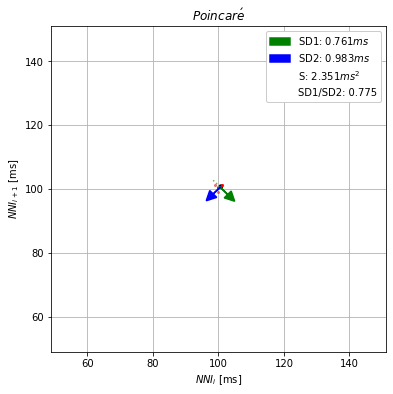

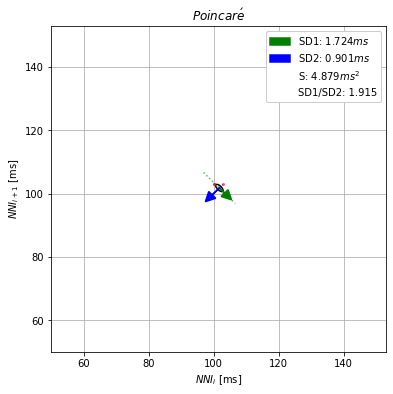

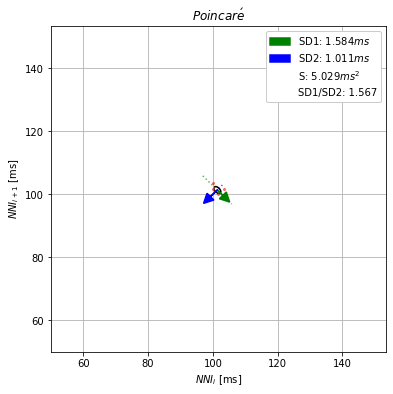

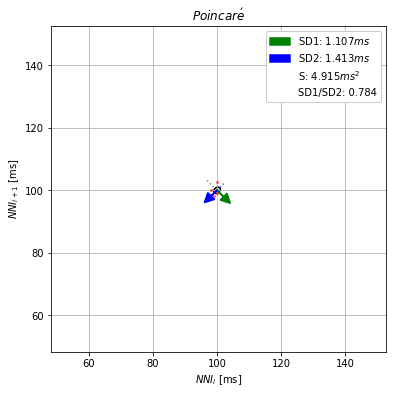

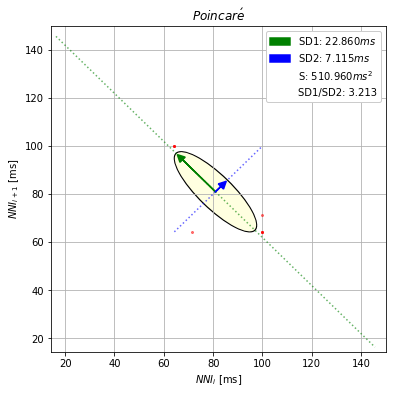

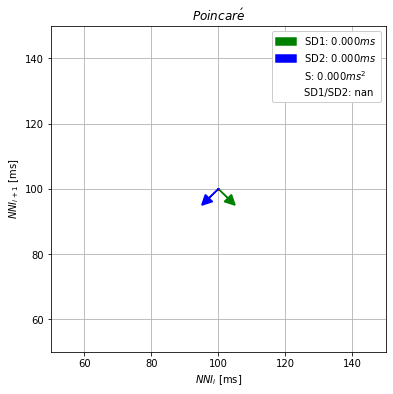

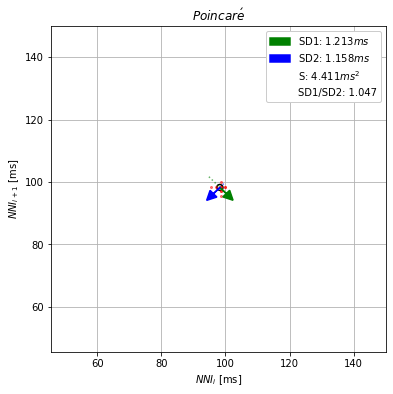

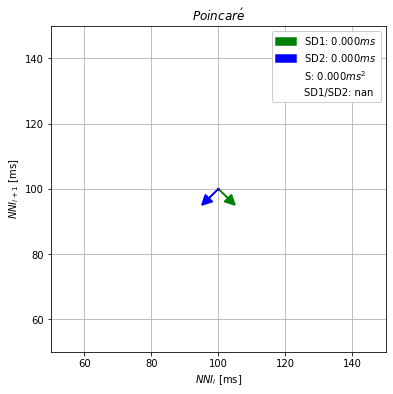

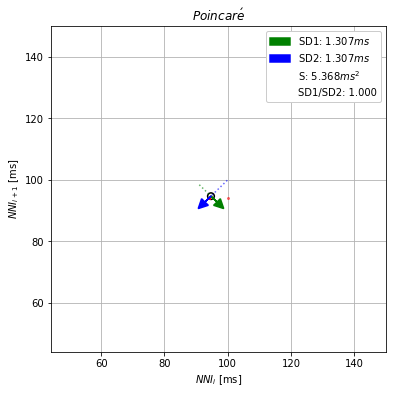

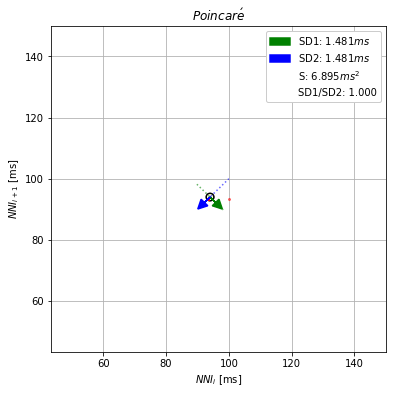

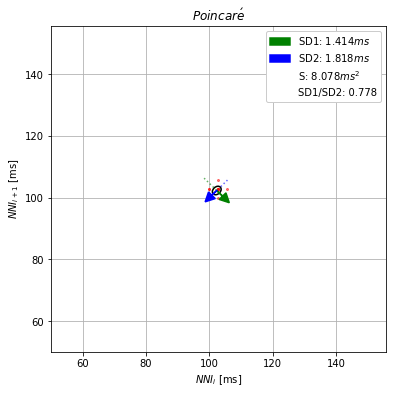

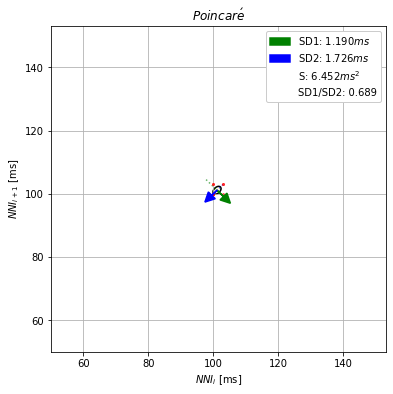

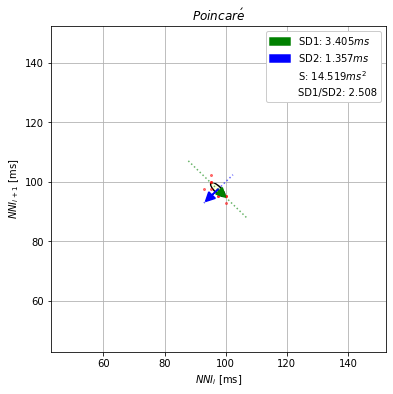

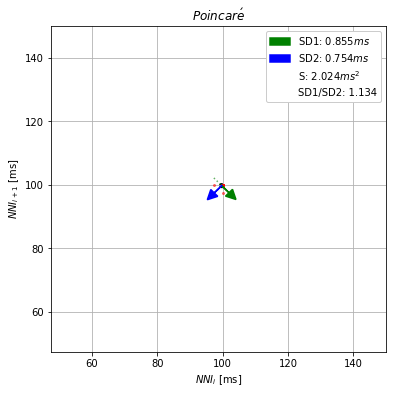

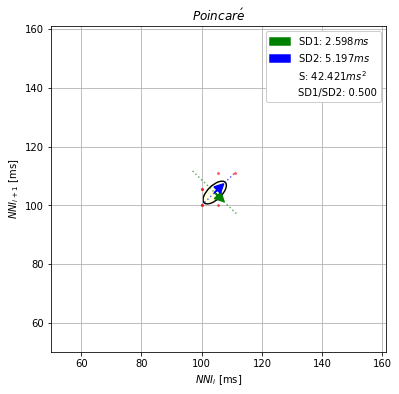

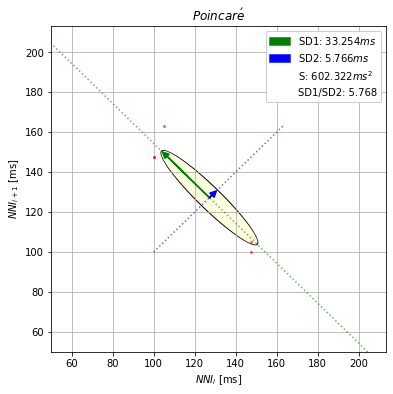

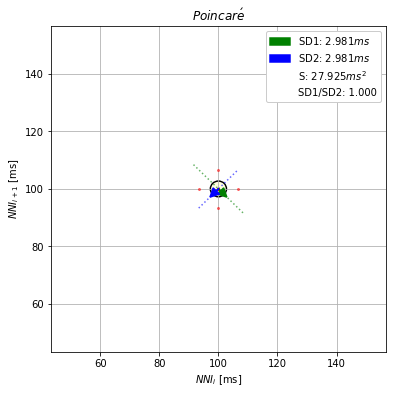

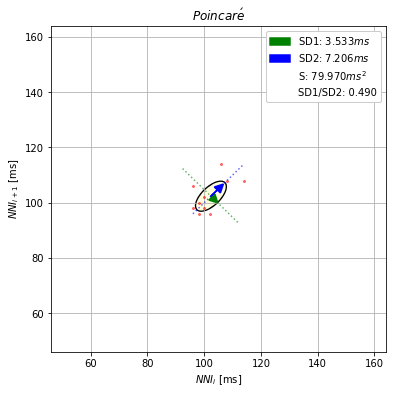

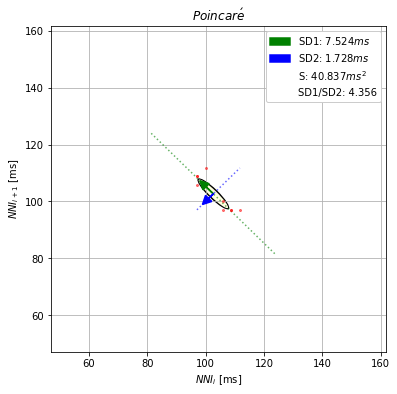

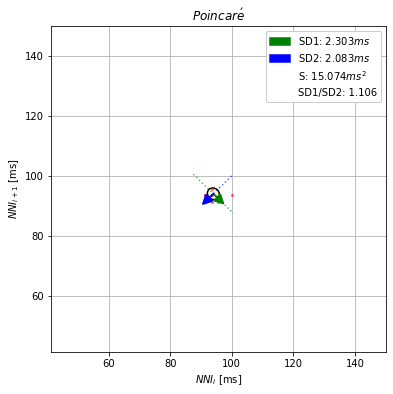

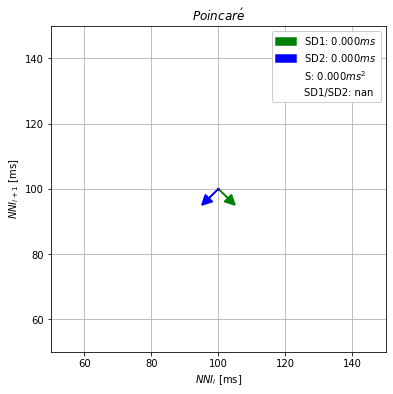

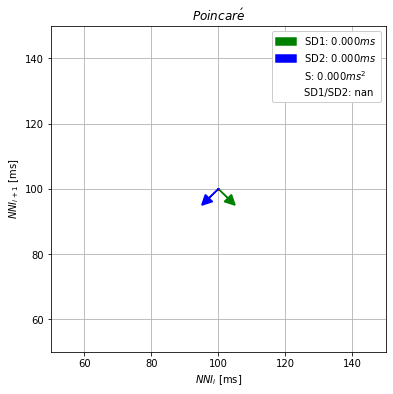

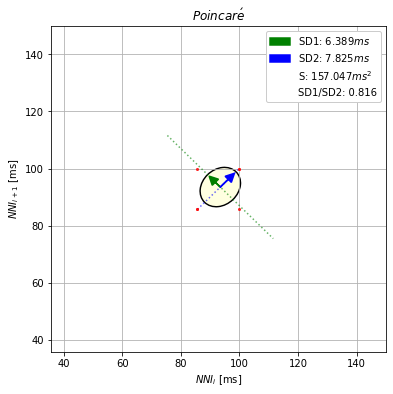

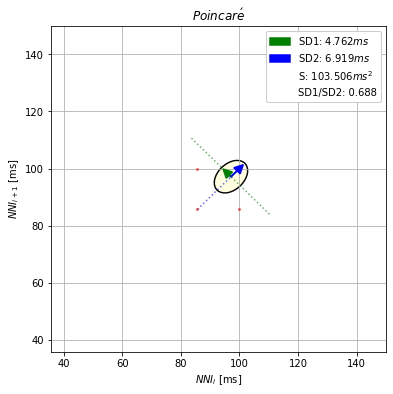

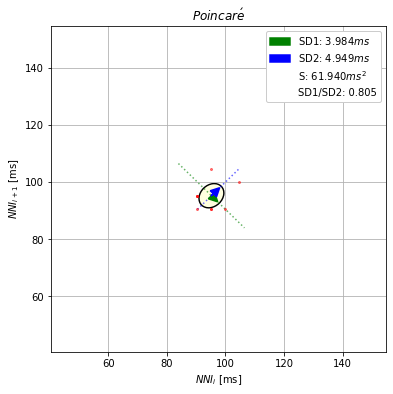

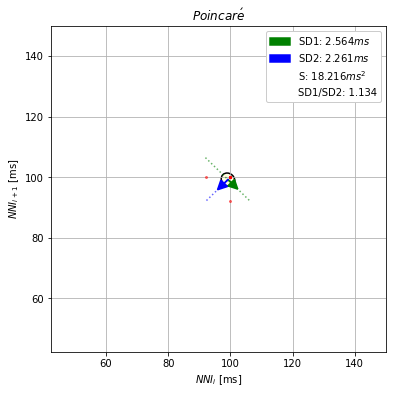

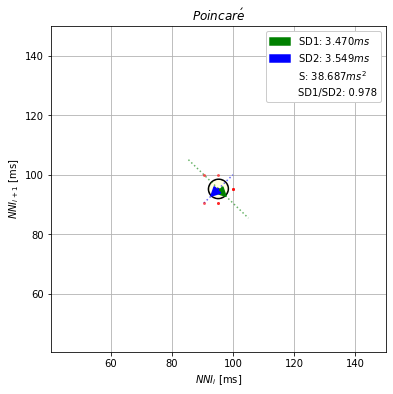

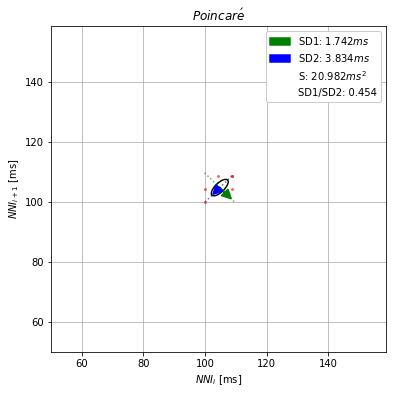

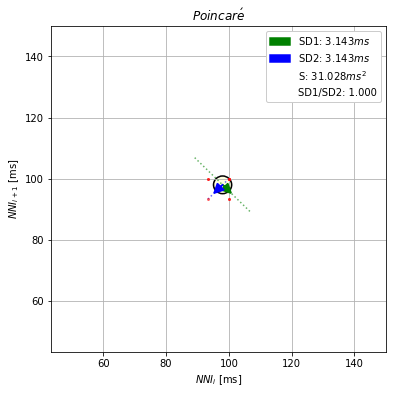

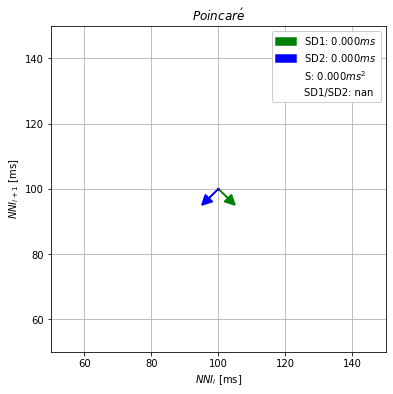

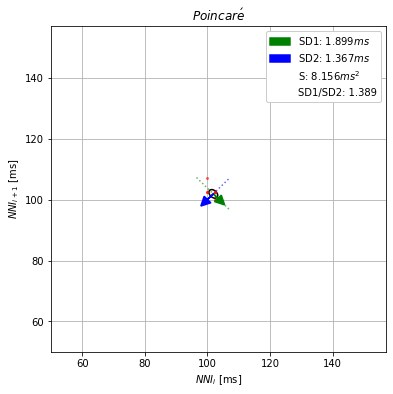

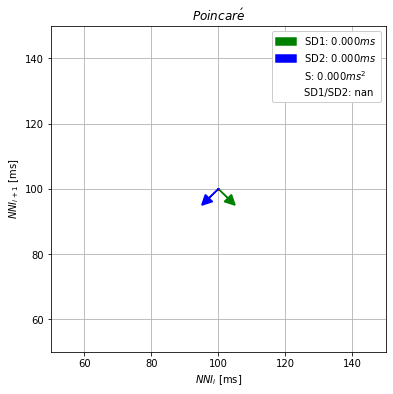

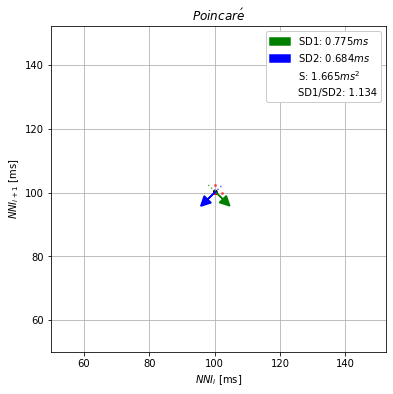

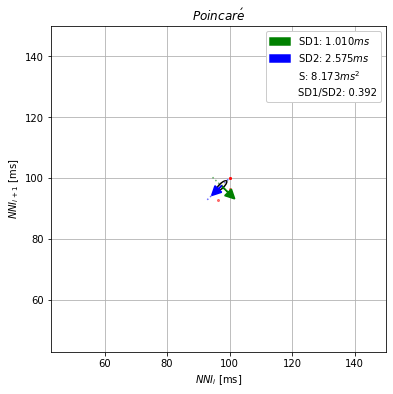

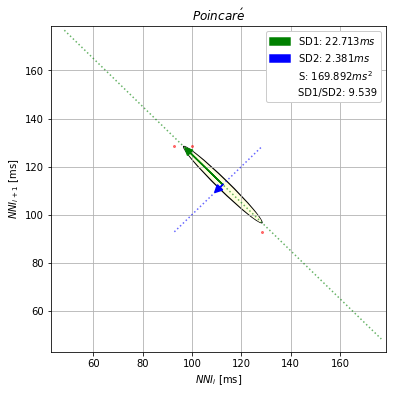

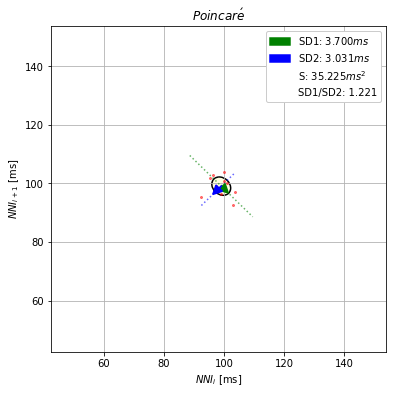

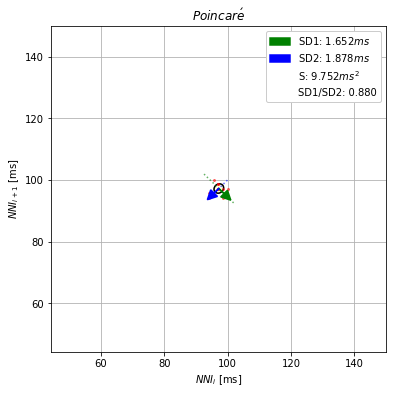

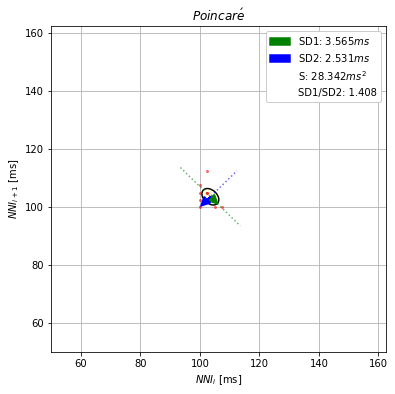

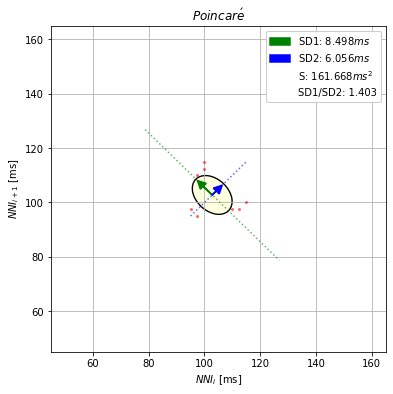

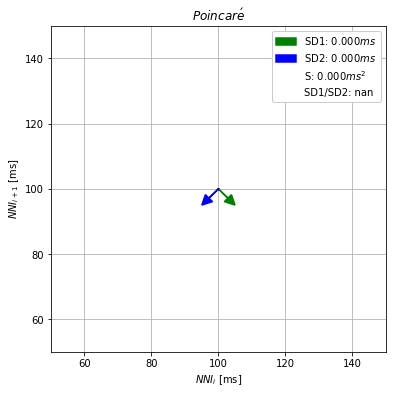

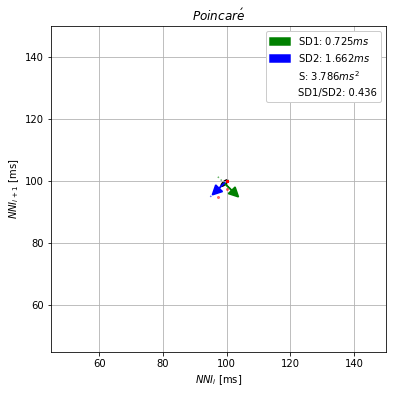

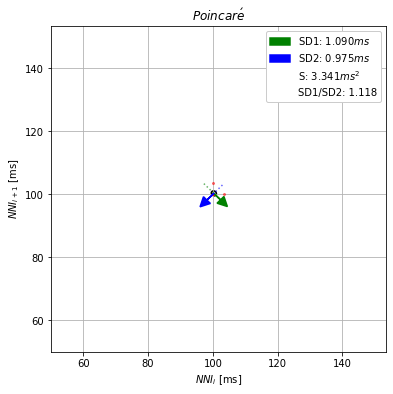

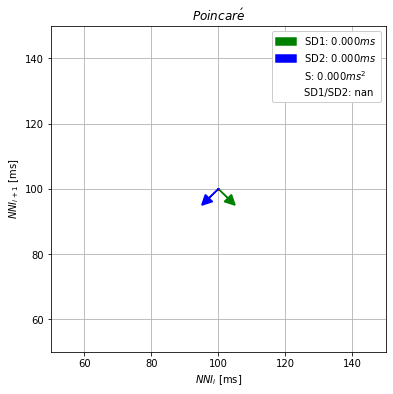

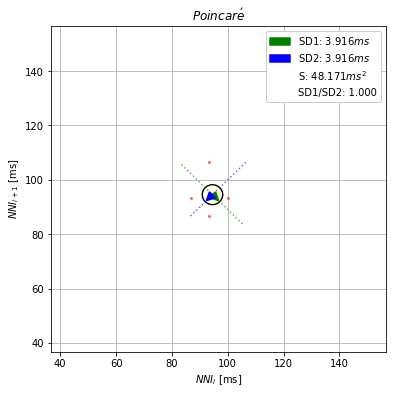

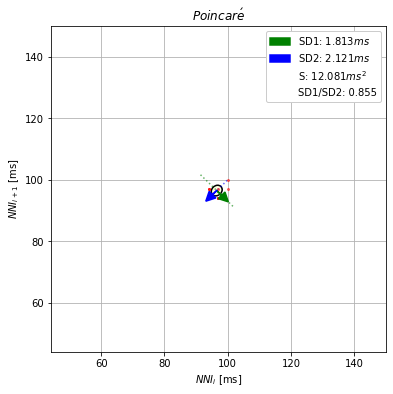

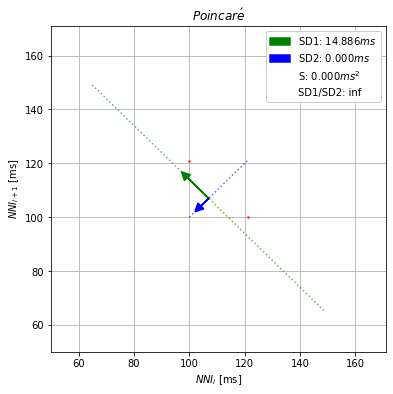

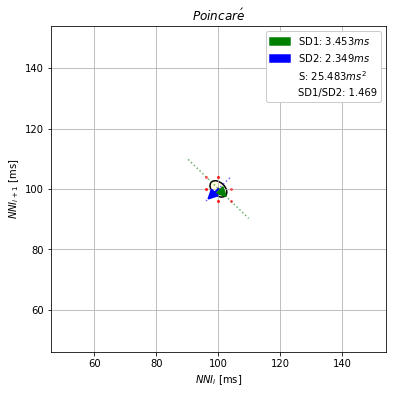

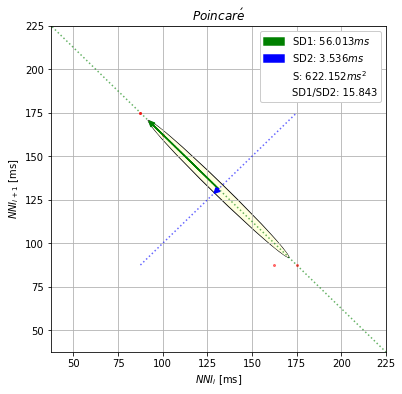

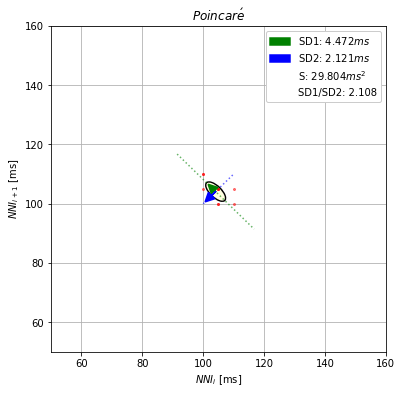

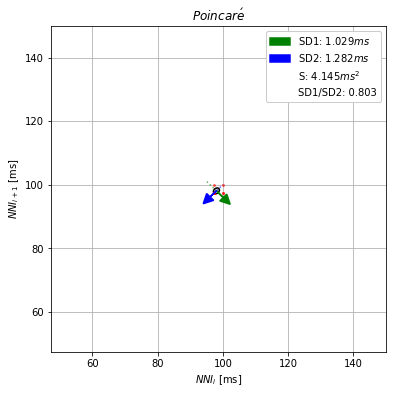

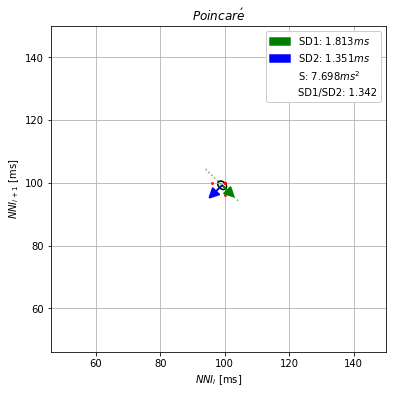

In [10]:
sd1 = []
sd2 = []
sd_ratio = []
for tabla in [tabulado_control5,tabulado_vk5,tabulado_dan5]:
    control_sd1 = []
    control_sd2 = []
    control_sd_ratio = []
    for i in range (len(tabla['mins'])):
        try:
            minimos = tabla['mins'][i]
            results = nl.poincare(minimos)
            control_sd1.append(results['sd1'])
            control_sd2.append(results['sd2'])
            control_sd_ratio.append(results[3])
        except:
            pass
    sd1.append(control_sd1)
    sd2.append(control_sd2)
    sd_ratio.append(control_sd_ratio)

In [11]:
for i in sd1:
    sd1_limpio = pd.DataFrame(i)#[outliers(pd.DataFrame(i))]
    print(sd1_limpio.median(),sd1_limpio.std())

0    1.878211
dtype: float64 0    7.789704
dtype: float64
0    2.789899
dtype: float64 0    7.109284
dtype: float64
0    1.813094
dtype: float64 0    12.640261
dtype: float64


In [17]:
scipy.stats.kstest(sd2[1],sd2[2])

KstestResult(statistic=0.30952380952380953, pvalue=0.2341456975675862)

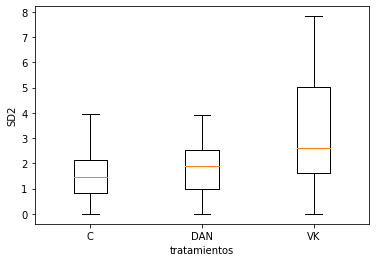

In [18]:
from matplotlib import pyplot

x = sd2[0]
y = sd2[2]
z = sd2[1]

fig = plt.figure()
pyplot.boxplot([x,y,z], 0,'')
pyplot.xlabel('tratamientos')
pyplot.xticks([1,2,3],['C','DAN','VK'])
pyplot.ylabel('SD2')
pyplot.show()
fig.savefig('SD2',dpi=300)

In [31]:
tabulado_vk5.to_excel(path + 'mins_vk para poincare' + '.xlsx', engine='xlsxwriter')  

In [29]:
# tabulado_dan5.to_csv(path + 'mins_dan para poincare')

TypeError: to_csv() got an unexpected keyword argument 'engine'

In [20]:
# tabulado_dan5 = pd.read_csv(path + 'mins_dan para poincare')

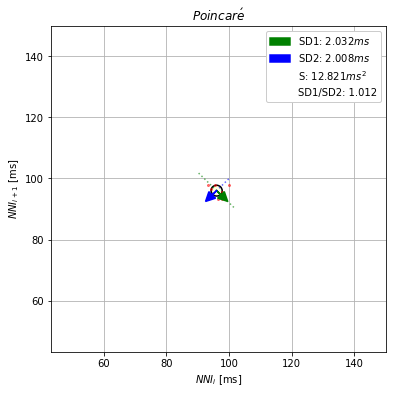

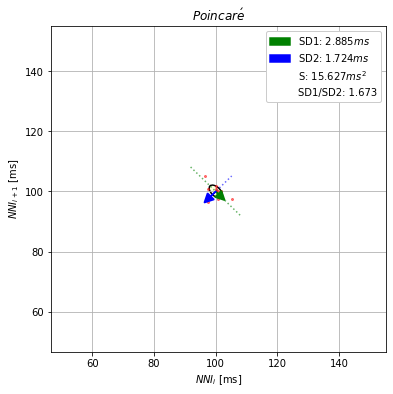

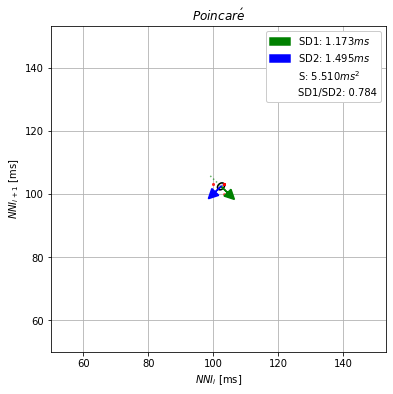

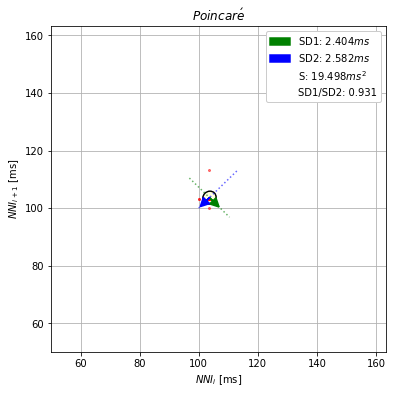

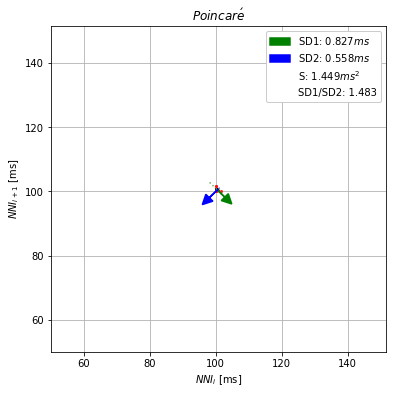

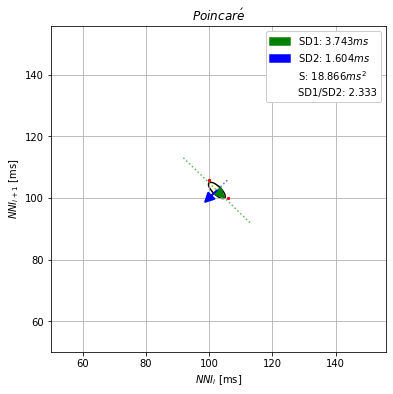

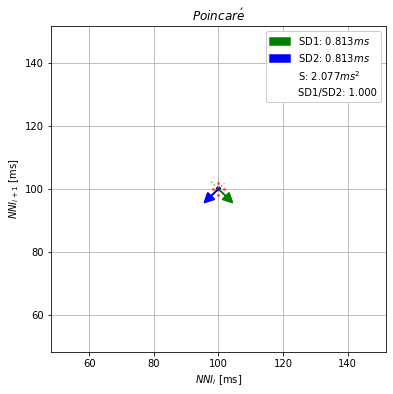

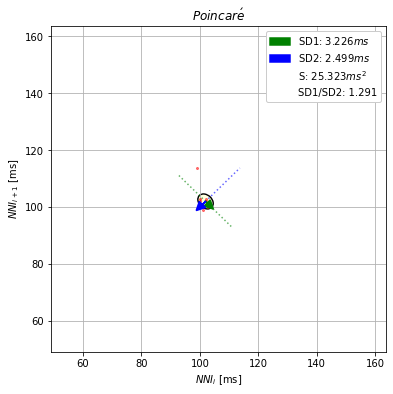

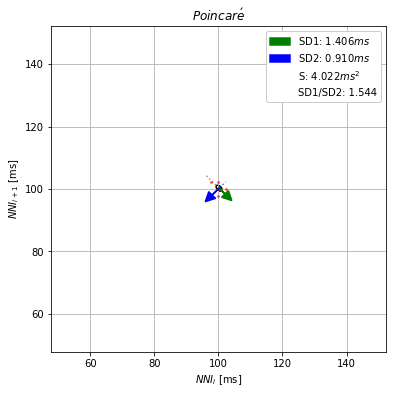

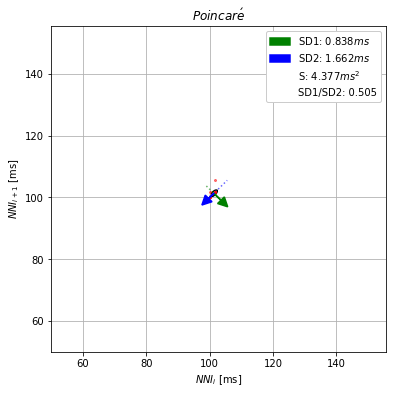

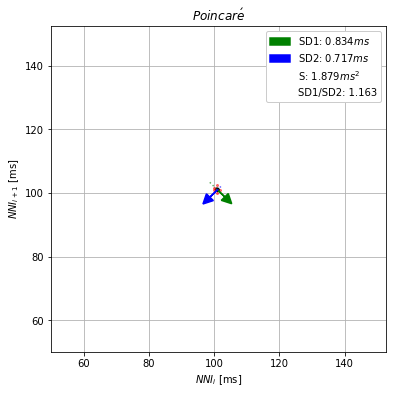

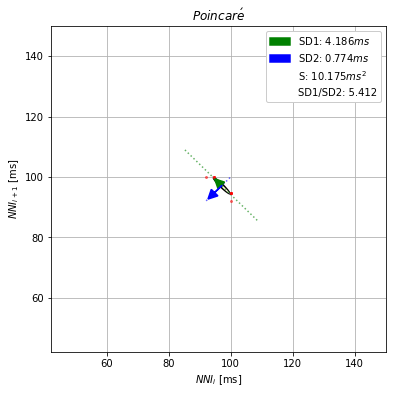

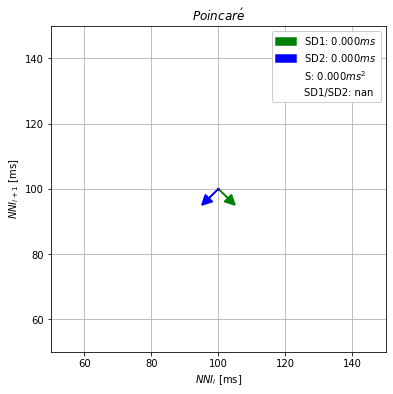

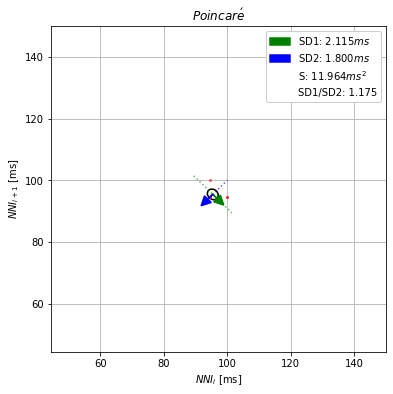

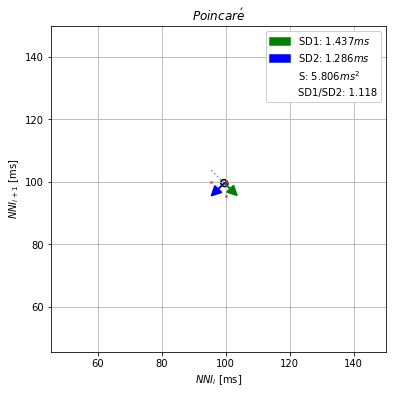

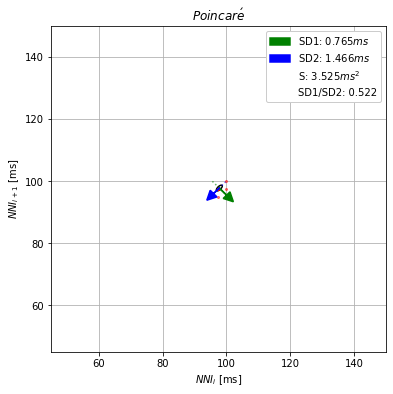

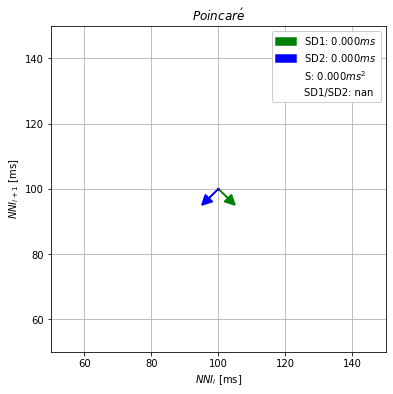

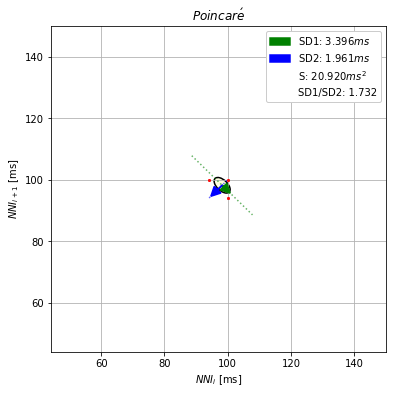

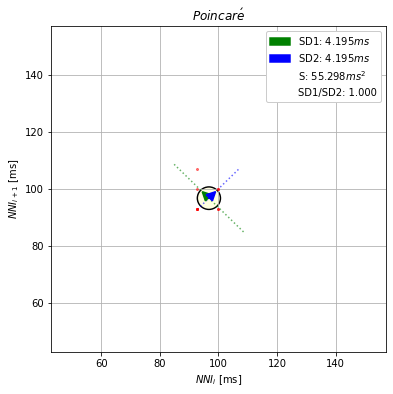

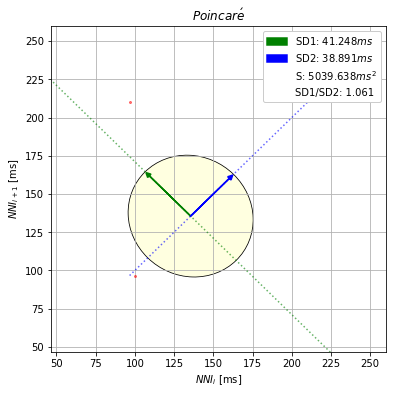

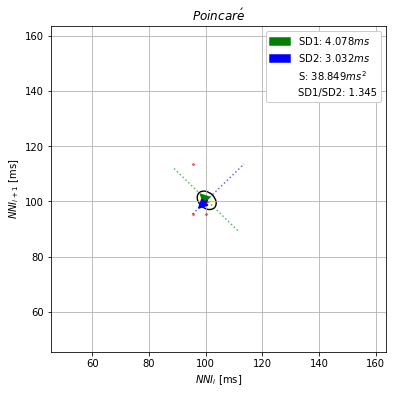

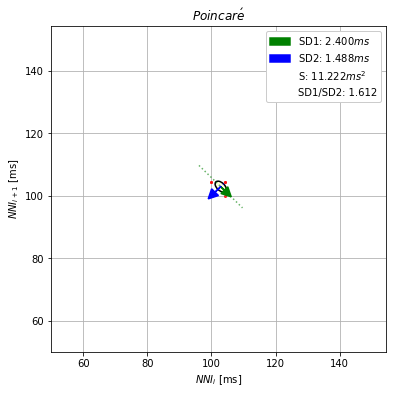

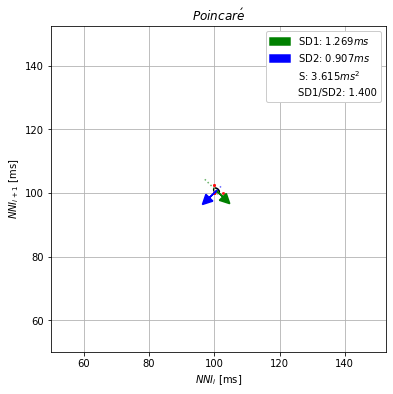

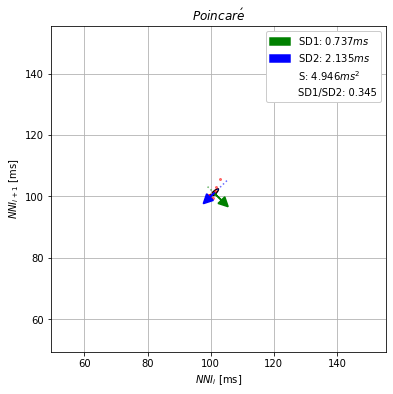

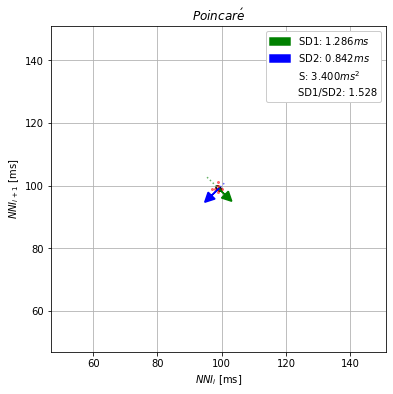

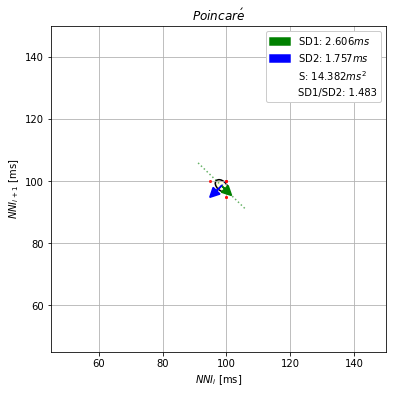

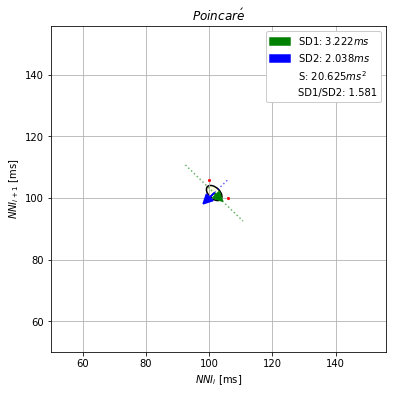

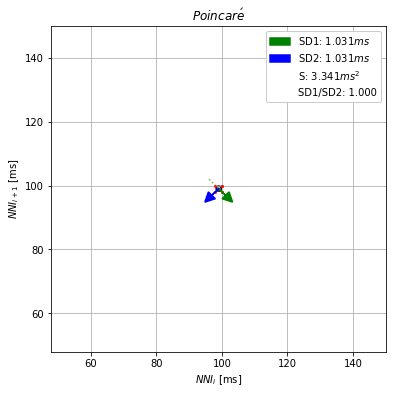

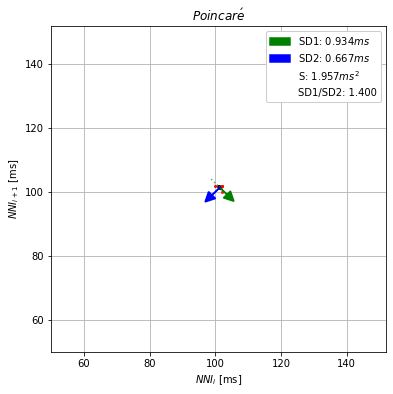

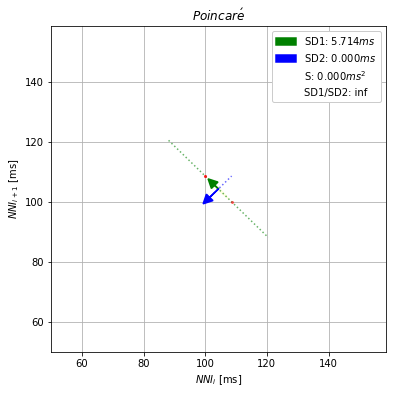

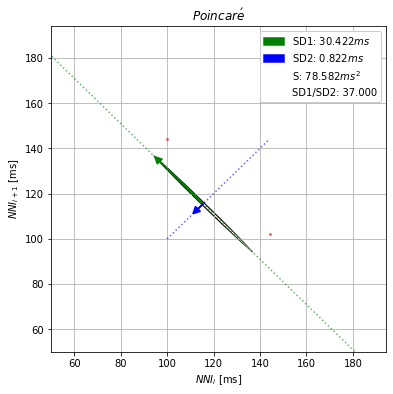

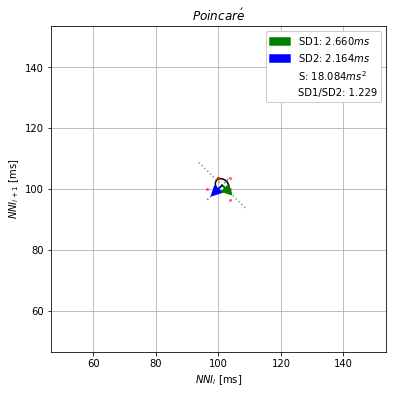

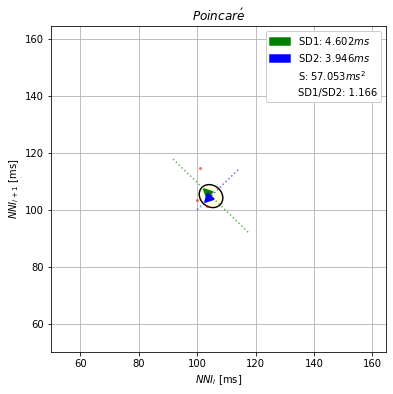

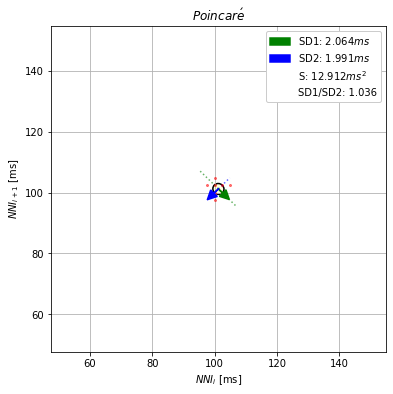

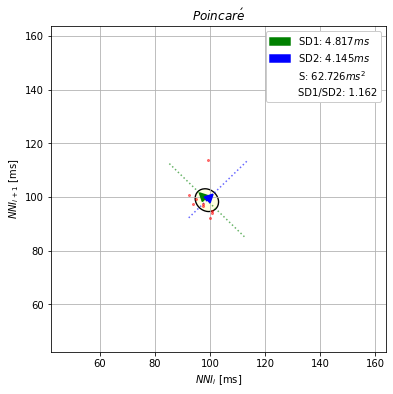

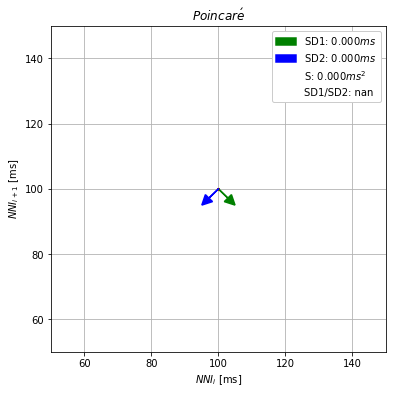

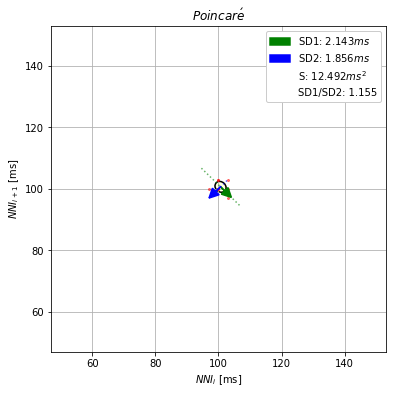

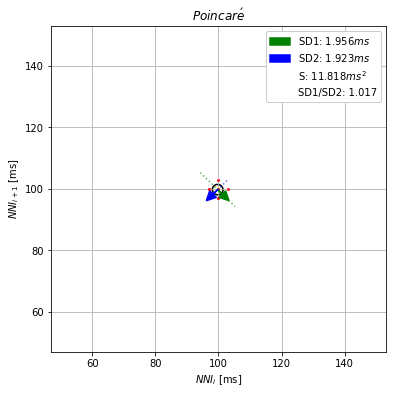

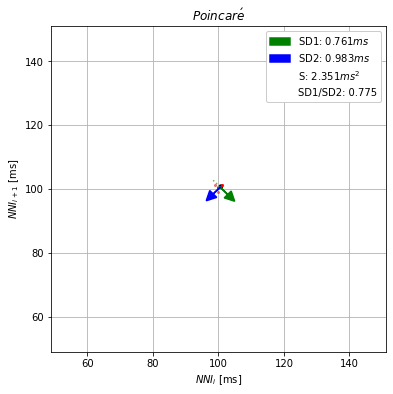

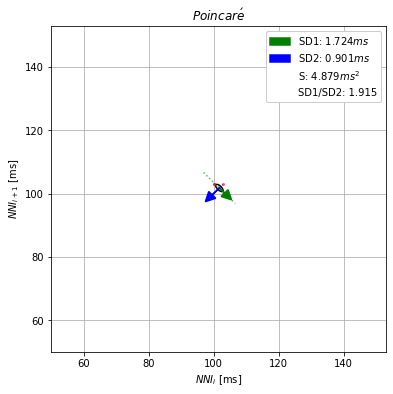

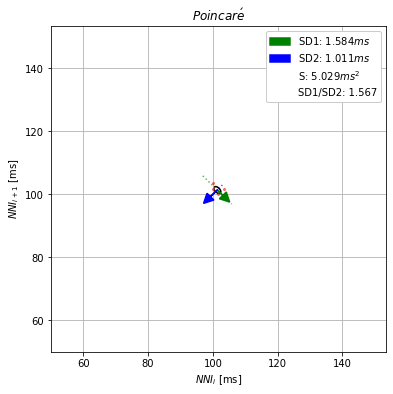

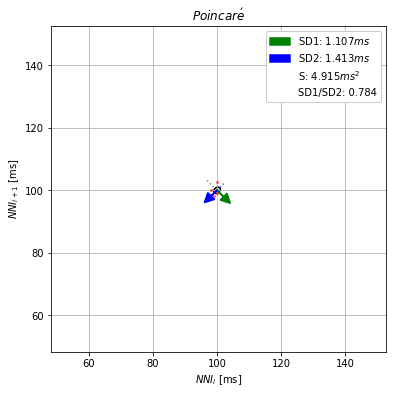

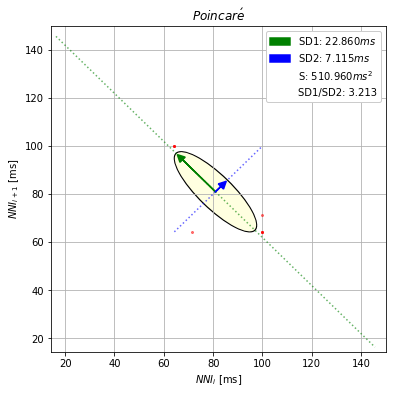

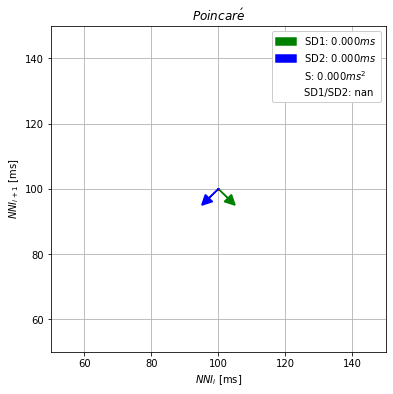

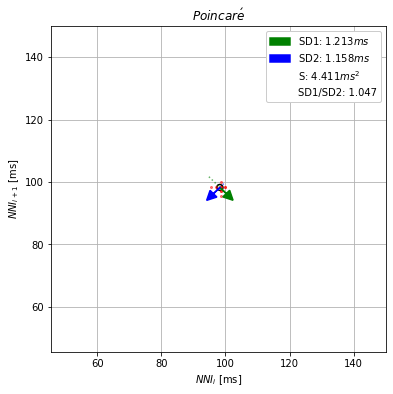

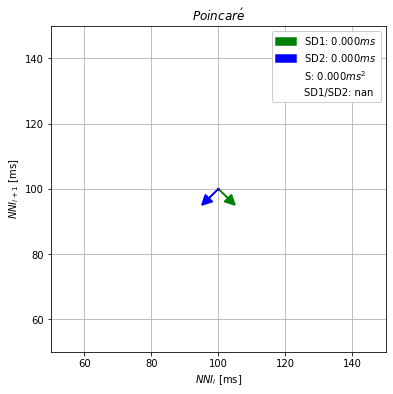

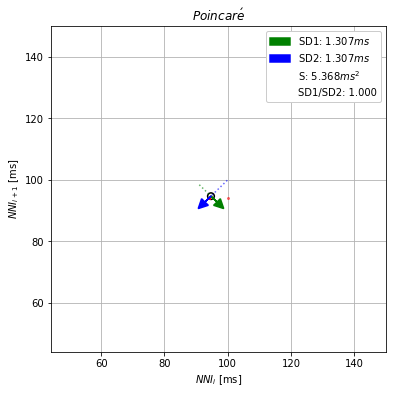

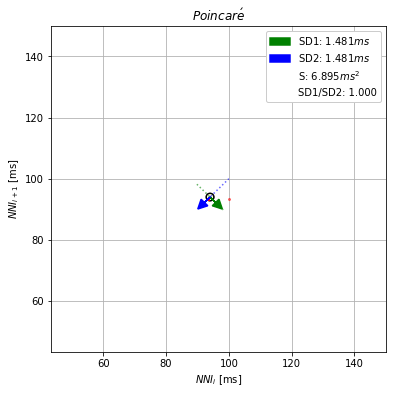

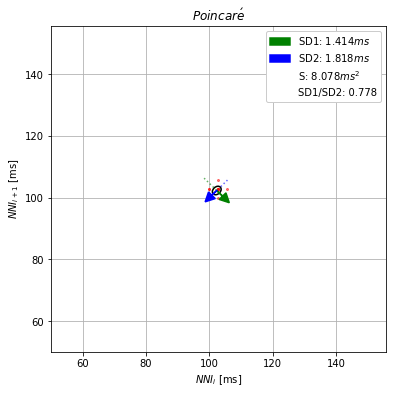

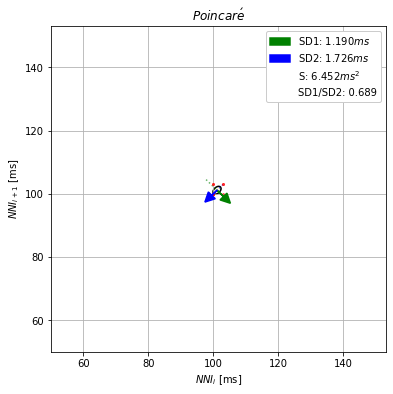

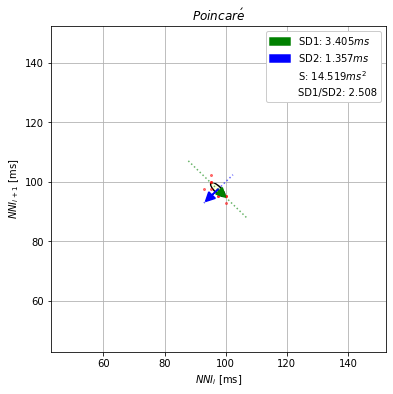

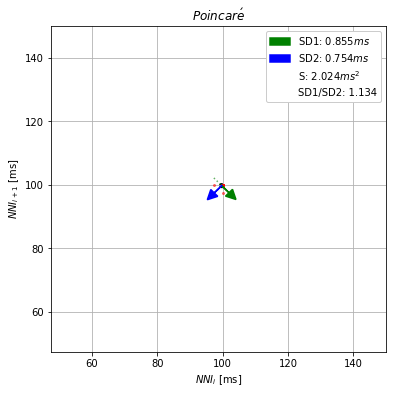

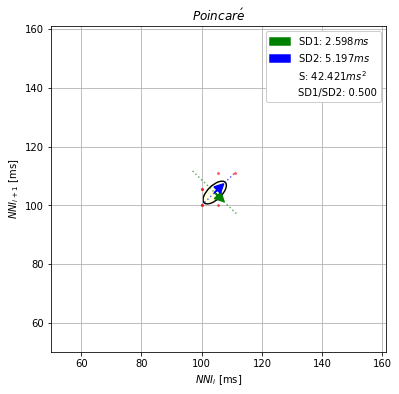

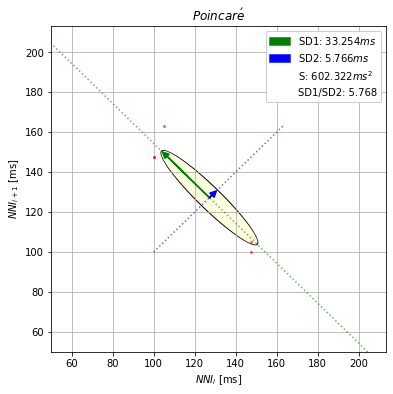

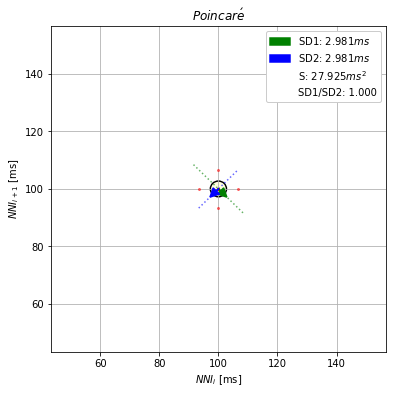

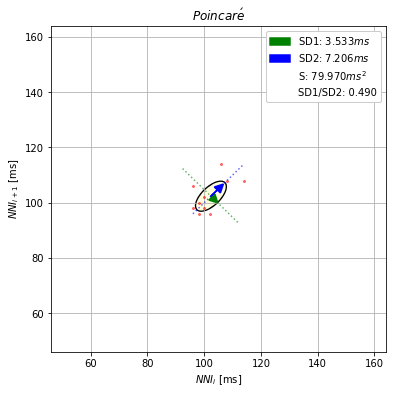

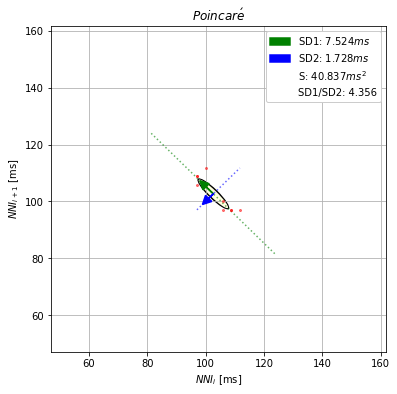

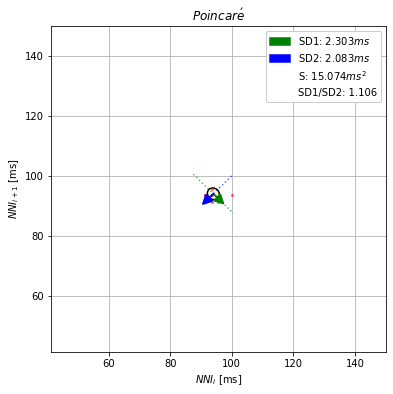

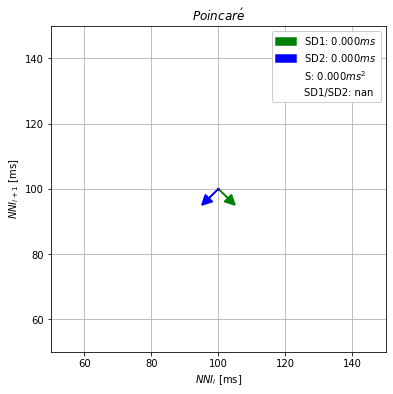

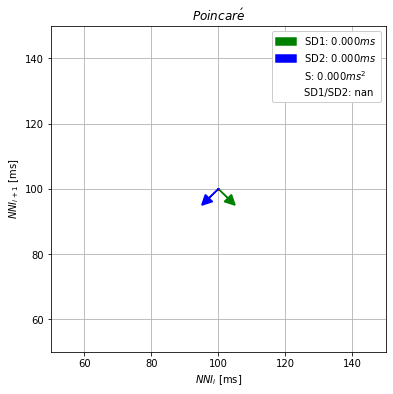

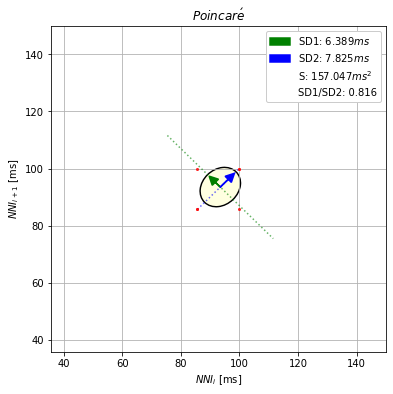

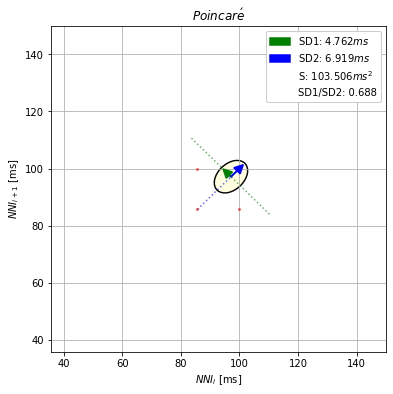

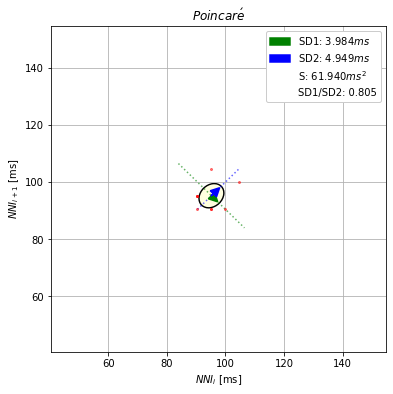

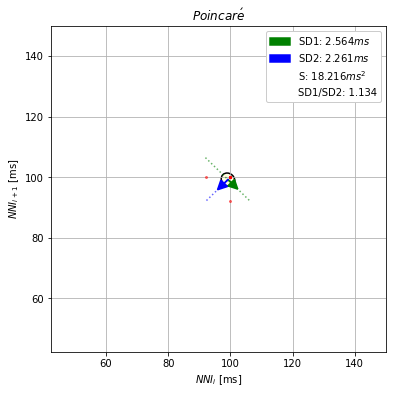

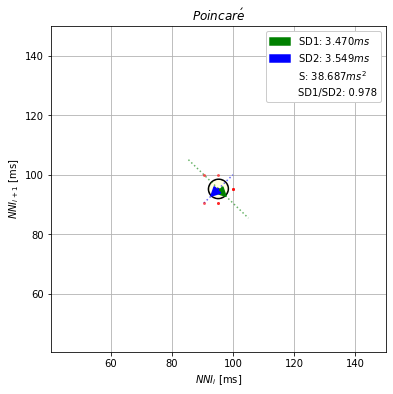

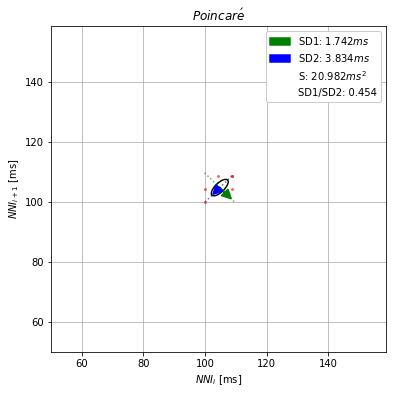

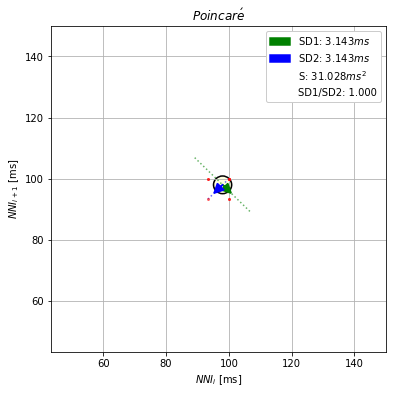

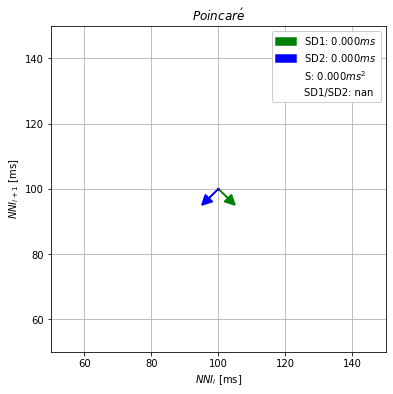

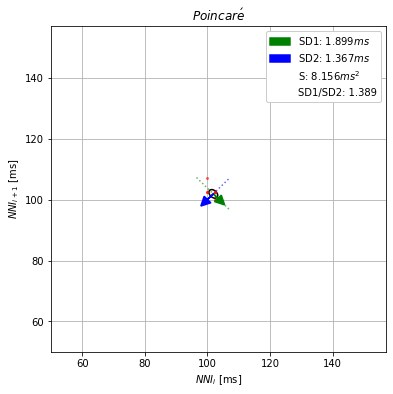

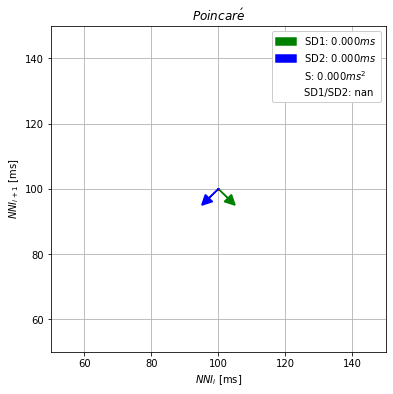

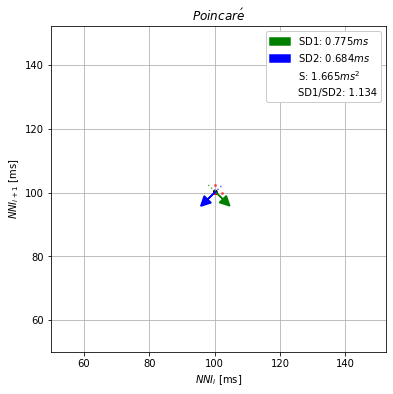

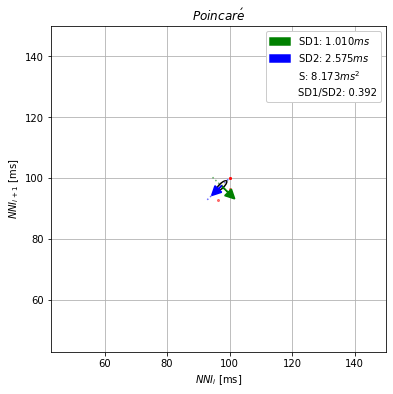

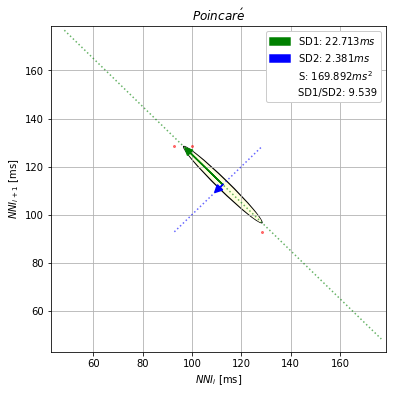

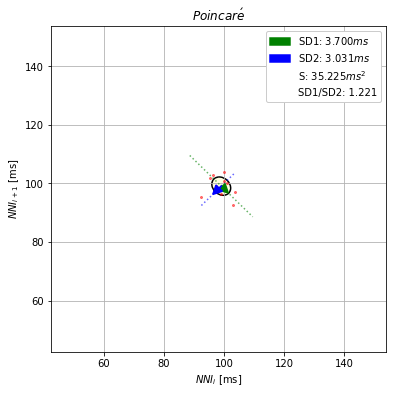

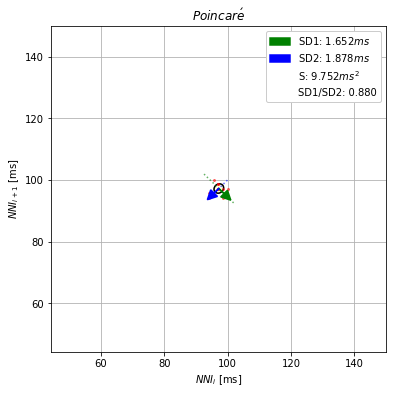

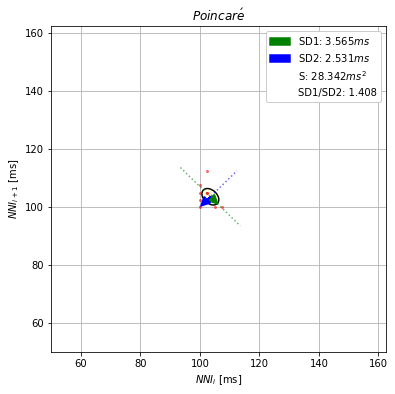

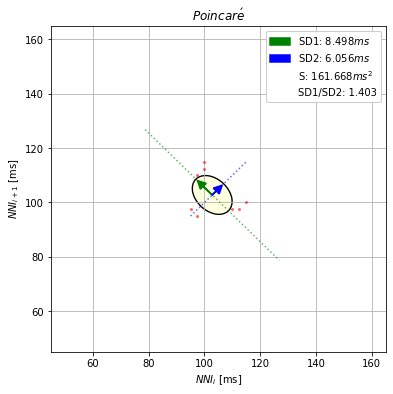

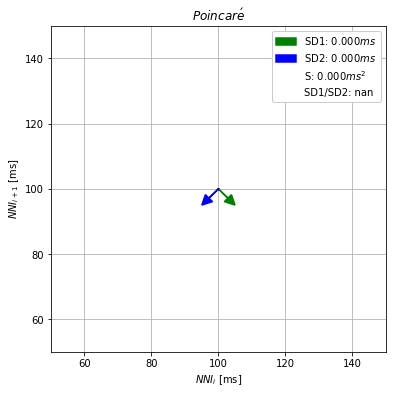

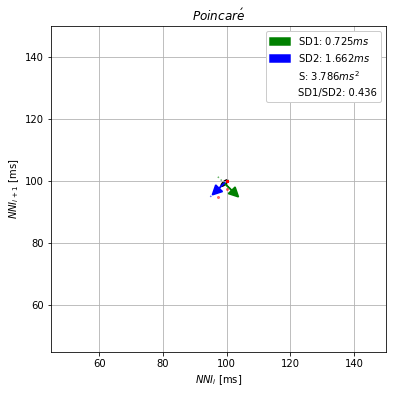

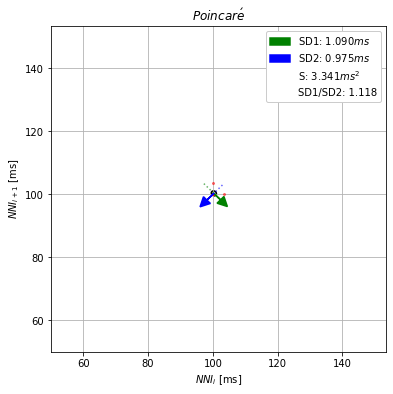

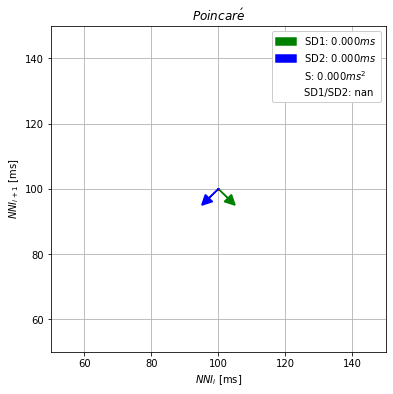

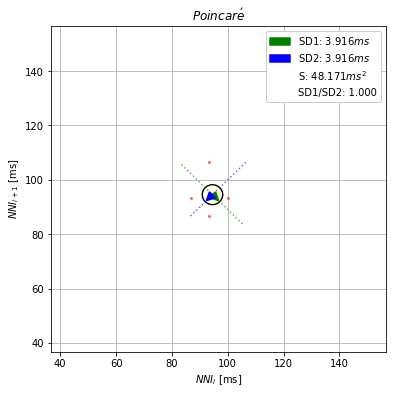

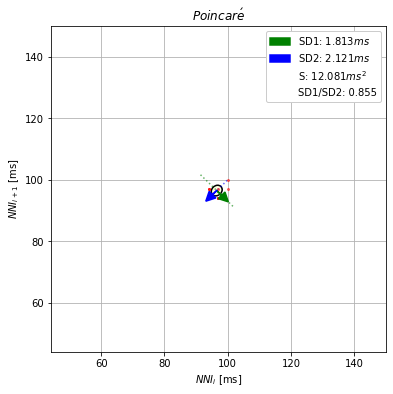

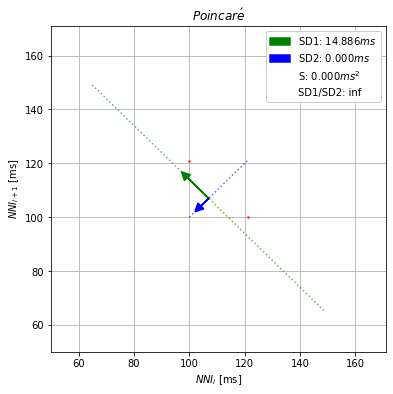

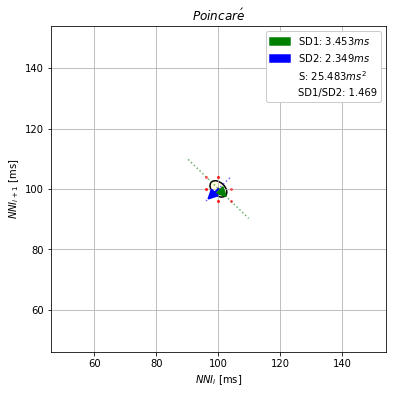

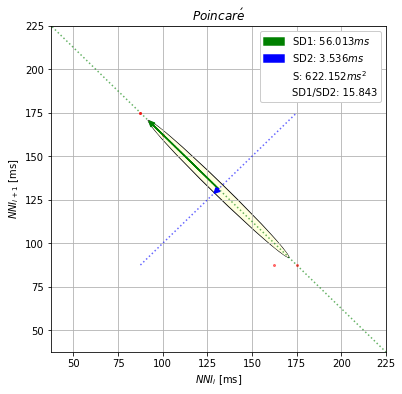

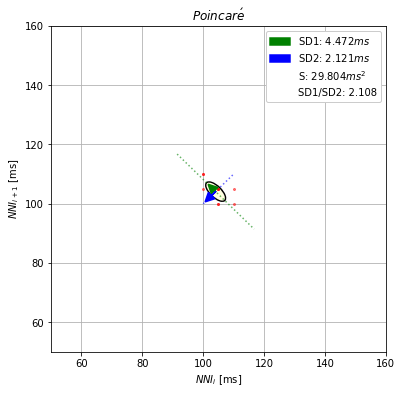

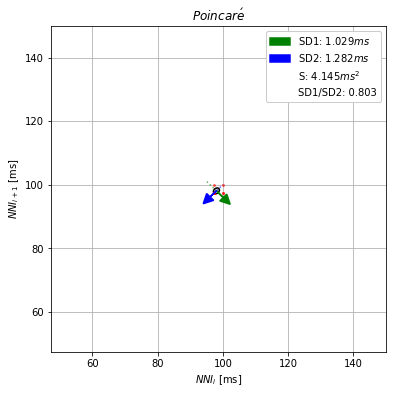

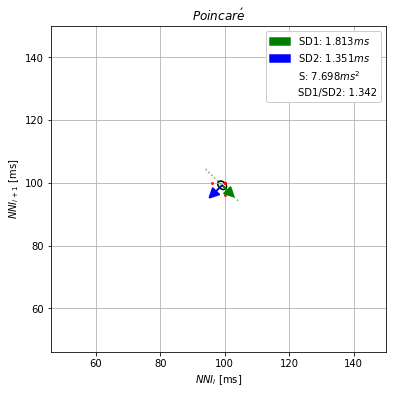

In [47]:
sd1 = []
sd2 = []
sd_ratio = []
length = len(tabulado_control5['mins'])
for tabla in [tabulado_control5,tabulado_vk5,tabulado_dan5]:
    control_sd1 = []
    control_sd2 = []
    control_sd_ratio = []
    for i in range (length):
        try:
            minimos = tabla['mins'][i]
            file = tabla['file'][i]
            results = nl.poincare(minimos)
            control_sd1.append([file,results['sd1']])
            control_sd2.append([file,results['sd2']])
            control_sd_ratio.append([file,results[3]])
        except:
            control_sd1.append([None,None])
            control_sd2.append([None,None])
            control_sd_ratio.append([None,None])            
    sd1.append(control_sd1)
    sd2.append(control_sd2)
    sd_ratio.append(control_sd_ratio)

In [48]:
df_sd1 = pd.DataFrame(sd1).T
df_sd2 = pd.DataFrame(sd2).T

In [49]:
df_control = pd.DataFrame({'file':pd.DataFrame(df_sd1[0].values.tolist())[0],'sd1':pd.DataFrame(df_sd1[0].values.tolist())[1],'sd2':pd.DataFrame(df_sd2[0].values.tolist())[1]})
df_vk = pd.DataFrame({'file':pd.DataFrame(df_sd1[1].values.tolist())[0],'sd1':pd.DataFrame(df_sd1[1].values.tolist())[1],'sd2':pd.DataFrame(df_sd2[1].values.tolist())[1]})
df_dan = pd.DataFrame({'file':pd.DataFrame(df_sd1[2].values.tolist())[0],'sd1':pd.DataFrame(df_sd1[2].values.tolist())[1],'sd2':pd.DataFrame(df_sd2[2].values.tolist())[1]})

In [50]:
df_control.to_excel(path + 'df_control1' + '.xlsx', engine='xlsxwriter')

In [57]:
df_control = pd.read_excel(path + 'df_control' + '.xlsx').dropna()
df_vk = pd.read_excel(path + 'df_vk' + '.xlsx').dropna()
df_dan = pd.read_excel(path + 'df_dan' + '.xlsx').dropna()

In [60]:
scipy.stats.kstest(df_control['sd2'],df_vk['sd2'])

KstestResult(statistic=0.4358974358974359, pvalue=0.04080873456674472)

In [22]:
df_control

,file,sd1,sd2
0,031019c4_analysis_result_c4e000.json,2.032005,2.008330
1,031019c1_analysis_result_c1e000.json,2.885035,1.724138
2,120121_analysis_result_3d000.json,10.491815,10.917601
3,120121_analysis_result_4d000.json,2.403701,2.581989
4,120121_analysis_result_2d000.json,0.827234,0.557721
5,120121_analysis_result_5d000.json,13.623250,12.299465
6,120121_analysis_result_1d000.json,0.813116,0.813116
7,121218SEL_analysis_result_1b000.json,3.225840,2.498725
8,071119c1sel_analysis_result_c1d001.json,1.406001,0.910493
9,170719c1_analysis_result_c1b000.json,0.838462,1.661515


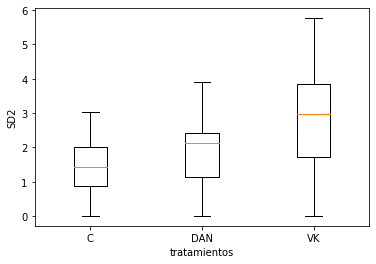

In [15]:
from matplotlib import pyplot

x = df_control['sd2'].dropna()
y = df_dan['sd2'].dropna()
z = df_vk['sd2'].dropna()

fig = plt.figure()
pyplot.boxplot([x,y,z], 0,'')
pyplot.xlabel('tratamientos')
pyplot.xticks([1,2,3],['C','DAN','VK'])
pyplot.ylabel('SD2')
pyplot.show()
# fig.savefig('SD2',dpi=300)

### Correlación SD vs DI

In [95]:
path = 'C:/Users/Leand/OneDrive/Documentos/Lean/Analizador_imagenes_calcio/Luis/analisis/'
DI_control = pd.read_csv(path + 'DI_control.csv')
DI_vk = pd.read_csv(path + 'DI_vk.csv')
DI_dan = pd.read_csv(path + 'DI_dan.csv')
df_control = pd.read_excel(path + 'df_control.xlsx')
df_vk = pd.read_excel(path + 'df_vk.xlsx')
df_dan = pd.read_excel(path + 'df_dan.xlsx')

In [96]:
def filtro_SD_DI(tabla_DI,tabla_SD):
    SD_DI = []
    for i in range(0,len(tabla_DI['file'])):
        cel = tabla_DI['file'][i]
        filtro = tabla_SD[(tabla_SD['file'].str.contains(cel) == True)]
        filtro['DI_5Hz'] = tabla_DI['DISCORDANCE 5 Hz'][i]
        del filtro['Unnamed: 0']
        SD_DI.append (filtro.values.tolist())
    return SD_DI,

In [109]:
SD_DI_control = filtro_SD_DI(DI_control,df_control)
sd_di_control = pd.DataFrame (SD_DI_control).T
x = pd.DataFrame(sd_di_control[0].to_list(), columns=['file','SD'])['file'].dropna()
x = pd.DataFrame(x.to_list(), columns=['file','SD1','SD2','DI'])

C:\Users\Leand\PyMOL\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\Leand\PyMOL\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\Leand\PyMOL\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/s

In [107]:
SD_DI_vk = filtro_SD_DI(DI_vk,df_vk)
sd_di_vk = pd.DataFrame (SD_DI_vk).T
y = pd.DataFrame(sd_di_vk[0].to_list(), columns=['file'])['file'].dropna()
y = pd.DataFrame(y.to_list(), columns=['file','SD1','SD2','DI'])

C:\Users\Leand\PyMOL\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [110]:
SD_DI_dan = filtro_SD_DI(DI_vk,df_vk)
sd_di_dan = pd.DataFrame (SD_DI_dan).T
z = pd.DataFrame(sd_di_dan[0].to_list(), columns=['file'])['file'].dropna()
z = pd.DataFrame(z.to_list(), columns=['file','SD1','SD2','DI'])

C:\Users\Leand\PyMOL\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


(0.2019842570765378, 0.16398825082467522)


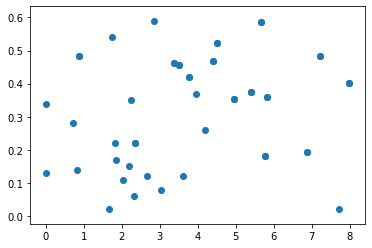

In [121]:
w = pd.concat([x,y,z], axis=0)
a = w['SD2'] 
b = w['DI']

print (pearsonr(a,b))
plt.scatter(a,b)

In [105]:
x

,file,SD1,SD2,DI
0,010719VK3_analysis_result_vk3b002.json,3.550846,7.988979,0.403029
1,010719VK7_analysis_result_vk7a000.json,4.187034,4.503471,0.523415
2,170719VK4_analysis_result_vk4b000.json,10.472276,5.821268,0.359029
3,170719VK7_analysis_result_vk7b000.json,4.101219,7.223573,0.484608
4,230819VK1_analysis_result_vk1d000.json,1.944407,4.391089,0.467583
5,230819VK2_analysis_result_vk2d000.json,3.984095,3.367175,0.463743
6,031019c2_analysis_result_c2f000.json,2.605787,3.503868,0.457584
7,031019c5_analysis_result_c5E000.json,0.988212,0.883883,0.484874
8,171019vk3_analysis_result_vk3e000.json,3.779645,3.779645,0.420581
9,311019vk2_analysis_result_vk2d000.json,7.993053,6.871843,0.192759


## JUNTAR ARCHIVOS DE IMÁGENES

In [20]:
import shutil
root = '/media/leandro/Volumen1TB/Lean/Analizador_imagenes_calcio/Luis/imagenes/'
for path, subdirs, files in os.walk(root):
    for name in files:
        if '.tif' in name:
            src = os.path.join(path, name)
            dst = root + 'todas/' + path.split('/')[-1] + '_' + name
            shutil.move(src,dst)